In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from torch.utils.data import DataLoader,ConcatDataset, TensorDataset
import torchvision
import matplotlib.patches as patches
import torchvision.transforms as transforms

import os
import time
import torch
import sys
import argparse
sys.path.insert(0, '../../shared_code')
# from network import *
from model_loader_func import * 
from dataloader_func import resize_image,add_noise_torch, rescale_image_range,int_to_float,rgb_to_gray, patch_generator, single_image_loader,load_dataset,prep_dataset
from quality_metrics_func import *
from linear_approx import *
from inverse_tasks_func import synthesis
from plotting_func import plot_many_denoised,  show_im_set, plot_single_im,plot_matching_patches
from algorithm_inv_prob import * 
from trainer import make_loader
from synthetic_data_generators import *

%matplotlib inline

In [2]:
print(torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

2.5.0+cu124


device(type='cuda')

In [3]:
# results_dir = '/mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/results/'


## Load denoisers


In [4]:
denoisers = {}


root_path = '/mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/'

paths = { 'mixture-gray':'UNet_flex/circles_squares_texture/0to255_RF_84x84_set_size_100000_gray_80x80/',           
            'conditional-gray':'UNet_conditional_mean_matching/circles_squares_texture/0to255_RF_84x84_set_size_100000_gray_80x80/'
        }

groups = paths.keys()

for group in groups: 
    path = root_path + paths[group]

    print('loading group ' , group )
    denoisers[group] = load_learned_model(path, print_args=True)
    start_time_total = time.time()        
    print("--- %s seconds ---" % (round(time.time() - start_time_total)))
     
    

loading group  mixture-gray
*************** saved arguments:*************
arch_name UNet_flex
lr 0.001
batch_size 512
num_epochs 1000
lr_freq 100
loss_weight False
noise_level_range [0, 255]
quadratic_noise True
rescale False
swap False
set_size 100000
imagenet_subset_ids None
self_cond False
data_name circles_squares_texture
data_root_path /mnt/home/zkadkhodaie/ceph/datasets/
dir_name /mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/UNet_flex/circles_squares_texture/0to255_RF_84x84_set_size_100000_gray_80x80
optional_dir_label gray
device cuda
debug False
kernel_size 3
padding 1
skip True
num_channels 1
bias True
RF 84
coarse True
num_kernels [64, 128, 256, 512]
num_blocks 3
num_enc_conv [2, 2, 2]
num_mid_conv 3
num_dec_conv [2, 2, 2]
NormType LayerNorm
match_only_mid True
nonlinear_enc True
******************************************************
number of parameters is  10022721
train mode: False
--- 0 seconds ---
loading group  conditional-gray
*************** s

In [5]:
denoisers.keys()

dict_keys(['mixture-gray', 'conditional-gray'])

In [6]:
blocks = ['enc1', 'enc2','enc3','mid','dec3', 'dec2']

denoisers['mixture-gray'].save_means

False

# Make datasets 

In [7]:
from synthetic_data_generators import generate_circles_texture, generate_squares_texture
def make_circles_squares_textures_dataset( set_size ,num=20, canvas_size=(80,80), min_side=5, max_side=10, edge_smoothness=.2 ):
    N = int(set_size/2)
 
    # train
    all_data_train = []
    circles = []
    for i in range(N):
        im = generate_circles_texture(num, canvas_size, min_side, max_side, edge_smoothness )
        circles.append(im)
    circles = torch.stack(circles).unsqueeze(1)
    all_data_train.append(circles)
    
    squares = []
    for i in range(N):
        im = generate_squares_texture(num, canvas_size, min_side*np.sqrt(2), max_side*np.sqrt(2), edge_smoothness )
        squares.append(im)
    squares = torch.stack(squares).unsqueeze(1)
    all_data_train.append(squares)

        # test
    N = 100
    all_data_test = []
    circles = []
    for i in range(N):
        im = generate_circles_texture(num, canvas_size, min_side, max_side, edge_smoothness )
        circles.append(im)
    circles = torch.stack(circles).unsqueeze(1)
    all_data_test.append(circles)
    
    squares = []
    for i in range(N):
        im = generate_squares_texture(num, canvas_size, min_side*np.sqrt(2), max_side*np.sqrt(2), edge_smoothness )
        squares.append(im)
    squares = torch.stack(squares).unsqueeze(1)
    all_data_test.append(squares)
    return all_data_train, all_data_test

In [8]:
train_sets, test_sets = make_circles_squares_textures_dataset(1000)

In [9]:
print('number of images in each class:', train_sets[0].shape)
K = train_sets[0].shape[2]
n_channels = train_sets[0].shape[1]
print(len(train_sets))


number of images in each class: torch.Size([500, 1, 80, 80])
2


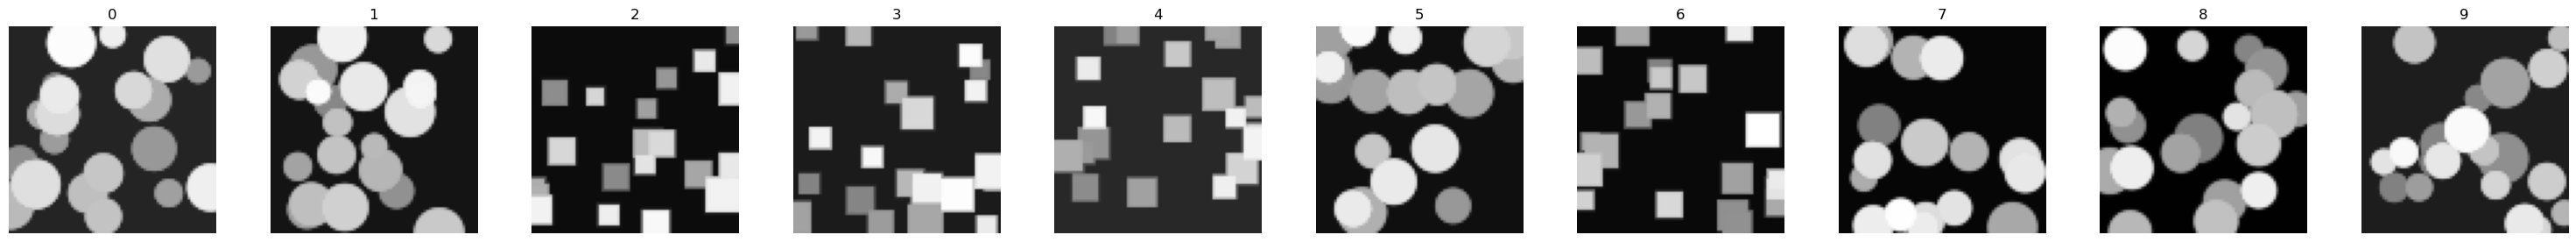

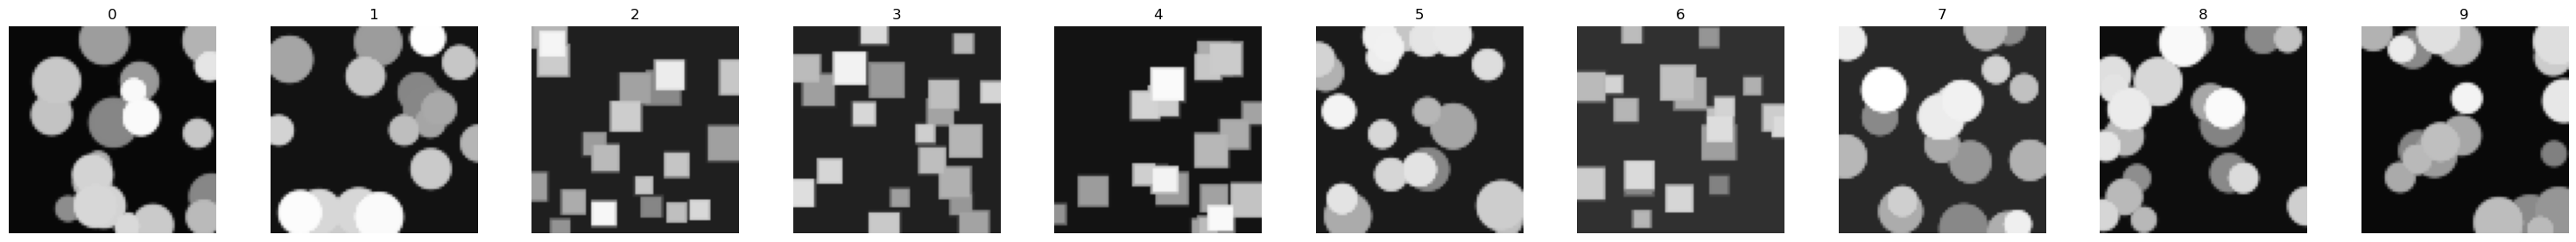

total number of train images: 1000


In [10]:
## shuffle train and test images and put them in one tensor 
loader, loader_cond = make_loader(dataset=train_sets, batch_size=512, dataset_cond=train_sets, self_cond =False)    
train ={}
train['inp']  = loader.dataset
train['cond'] = loader_cond.dataset
show_im_set(train['inp'][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(train['cond'][0:10], n_columns=10, vmin=0, vmax = 1 )
print('total number of train images:',train['inp'].shape[0])


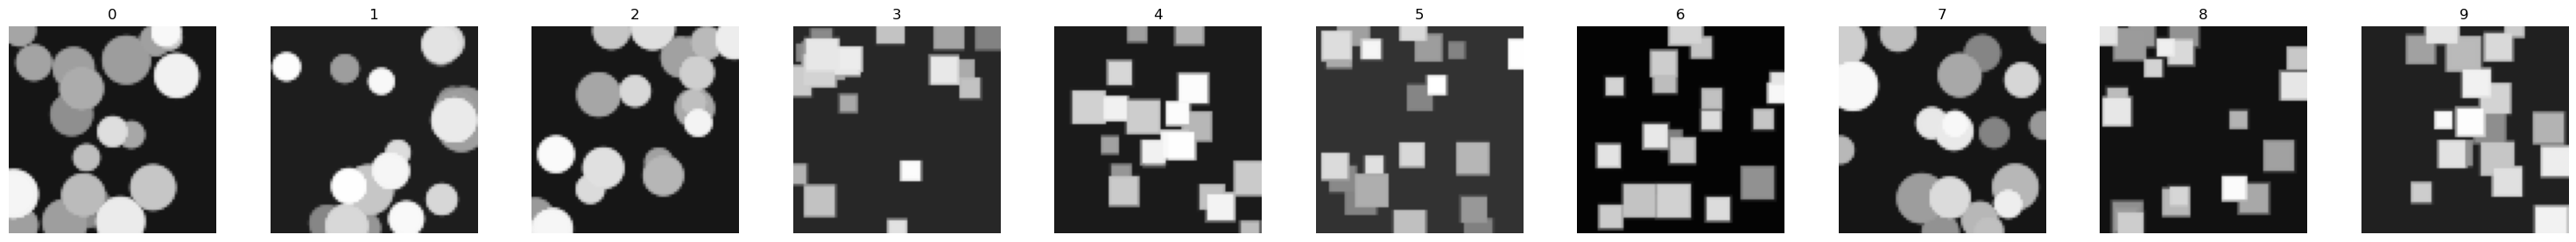

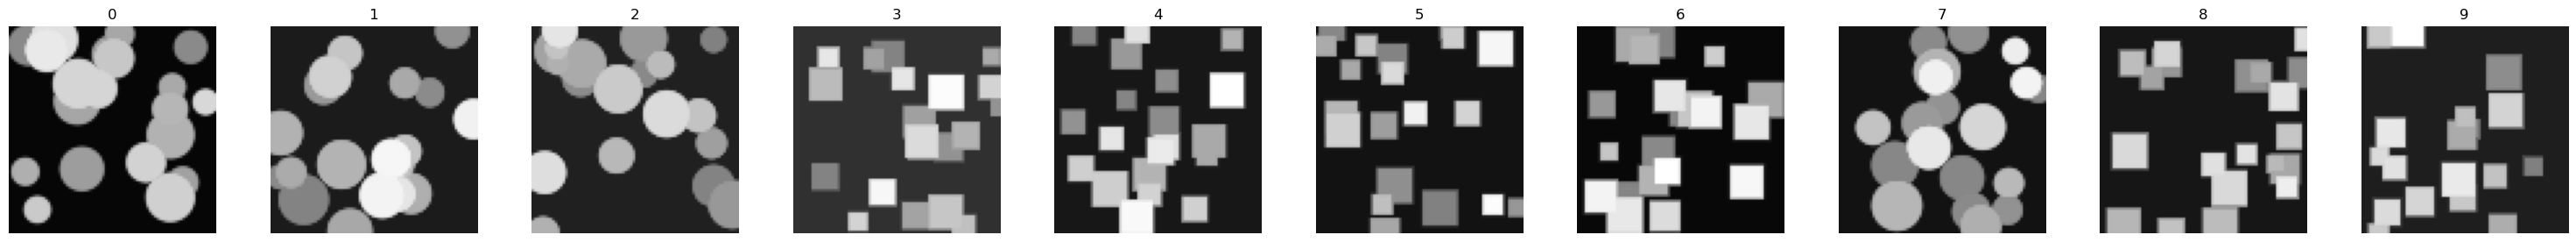

total number of test images: 200


In [11]:
loader, loader_cond = make_loader(dataset=test_sets, batch_size=256, dataset_cond=test_sets, self_cond =False)        
test ={}
test['inp']  = loader.dataset[0:1024]
test['cond'] = loader_cond.dataset[0:1024]
show_im_set(test['inp'][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(test['cond'][0:10], n_columns=10, vmin=0, vmax = 1)
print('total number of test images:',test['inp'].shape[0])


tensor(0.3256)


80

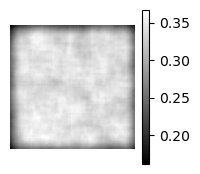

In [12]:
dist_mean = train['inp'].mean(0)
plot_single_im(dist_mean, colorbar=True)
print(dist_mean.mean())
K = dist_mean.shape[2]
K

In [13]:
for i in range(len(train_sets)): 
    print(train_sets[i].mean())

tensor(0.3695)
tensor(0.2818)


# auxilary functions 

In [14]:
def get_channel_means(unet, im_cond, device=device, average_phi=False, with_params=True, return_activations = False): 
    '''
    returns means of channels of a UNet_flex operating on noisy
    @noisy: of shape N,C,H,W
    @with_param: important: set to False if phi is computed to be given to the network (instead of x)
    '''    

    unet.save_means = True    
    if return_activations: 
        unet.save_activations = True
        
    with torch.no_grad():
        try: 
            out = unet(im_cond.to(device), im_cond.to(device), average_phi)
            x_c_means = unet.stored_x_c_means
            x_c = unet.stored_x_c
            
        except TypeError: # for the unconditionaa model
            out = unet(im_cond.to(device))
            x_c_means = unet.stored_x_c_means
            x_c = unet.stored_x_c
            if average_phi: 
                for i in range(len(x_c_means)): 
                    x_c_means[i] = x_c_means[i].mean(0,keepdim=True)
            
    
    unet.save_means = False
    unet.save_activations = False


    if with_params:   
        try:
            params = get_matching_params(unet)
            for i in range(len(params)): 
                x_c_means[i] = x_c_means[i] * params[i]
        except AttributeError: 
            pass

    if return_activations: 
        return x_c_means, x_c
    else: 
        return x_c_means


        

def get_matching_params(unet): 
    params = []
    for l in range(len(unet.encoder_matching_params)):
        params.append(unet.encoder_matching_params[str(l)].detach().to(device))
    params.append(unet.mid_matching_params.detach().to(device))
    for l in range(len(unet.decoder_matching_params)-1, 0,-1):
        params.append(unet.decoder_matching_params[str(l)].detach().to(device))
    return params

# Synthesis from mixture model

In [16]:
groups


dict_keys(['mixture-gray', 'conditional-gray'])

In [61]:
# init image mean set ot category mean. What's its effetc?

n_samples =10

seed = 0
freq =100
sig_L = .1
h0= .01
beta = .02

fixed_h =True
all_samples = {}
all_interm_Ys = {}
all_init = []
K = 80
start_time_total = time.time()

for group in ['mixture-gray']: 
    if seed is not None:
        torch.manual_seed(seed)
        

    
    print('--------- group : ', group)        
    all_samples[group] = {}
    all_interm_Ys[group] = {}            
    temp = []
    for _ in range(3):    
        if 'color' in group.split('-'): 
            n_channels = 3
            init_im = dist_mean.to(device)+ torch.randn(n_samples,n_channels ,K,K, device = device)        
            
        else: 
            n_channels = 1        
            init_im = dist_mean.mean(dim=0,keepdim=True).to(device)+ torch.randn(n_samples,n_channels ,K,K, device = device)
            # init_im = train_sets[0].mean(dim=0,keepdim=True).to(device)+ torch.randn(n_samples,n_channels ,K,K, device = device)

        
        sample, interm_Ys,_, _ = batch_synthesis(denoisers[group],
                                              (n_samples,n_channels, K,K),
                                              init_im=init_im, 
                                              sig_0=1, 
                                              sig_L=sig_L, 
                                              h0=h0, 
                                              beta=beta, 
                                              freq=freq,
                                              device=device, 
                                              fixed_h = fixed_h,
                                              max_T=10000, 
                                              seed= seed
                                              )
                    
        temp.append(sample.detach())    
    
    all_samples[group] = torch.cat(temp)
    all_interm_Ys[group] = interm_Ys
    
            
print("--- %s seconds ---" % (time.time() - start_time_total))

--------- group :  mixture-gray
----------------------------- 100
sigma  0.8079208731651306
mean  0.311097115278244
----------------------------- 200
sigma  0.78179532289505
mean  0.3097691237926483
----------------------------- 300
sigma  0.7577373385429382
mean  0.308023065328598
----------------------------- 400
sigma  0.7349870800971985
mean  0.3113786578178406
----------------------------- 500
sigma  0.7068753242492676
mean  0.31369149684906006
----------------------------- 600
sigma  0.6858243346214294
mean  0.3107004463672638
----------------------------- 700
sigma  0.6503452658653259
mean  0.314826637506485
----------------------------- 800
sigma  0.6286526322364807
mean  0.32416945695877075
----------------------------- 900
sigma  0.6066249012947083
mean  0.32664716243743896
----------------------------- 1000
sigma  0.5819632411003113
mean  0.3299543559551239
----------------------------- 1100
sigma  0.5654497146606445
mean  0.3257697820663452
----------------------------- 120

fixed_h= True  sig_L=  0.1  h0= 0.01  beta= 0.1  seed= 0  group= mixture-gray


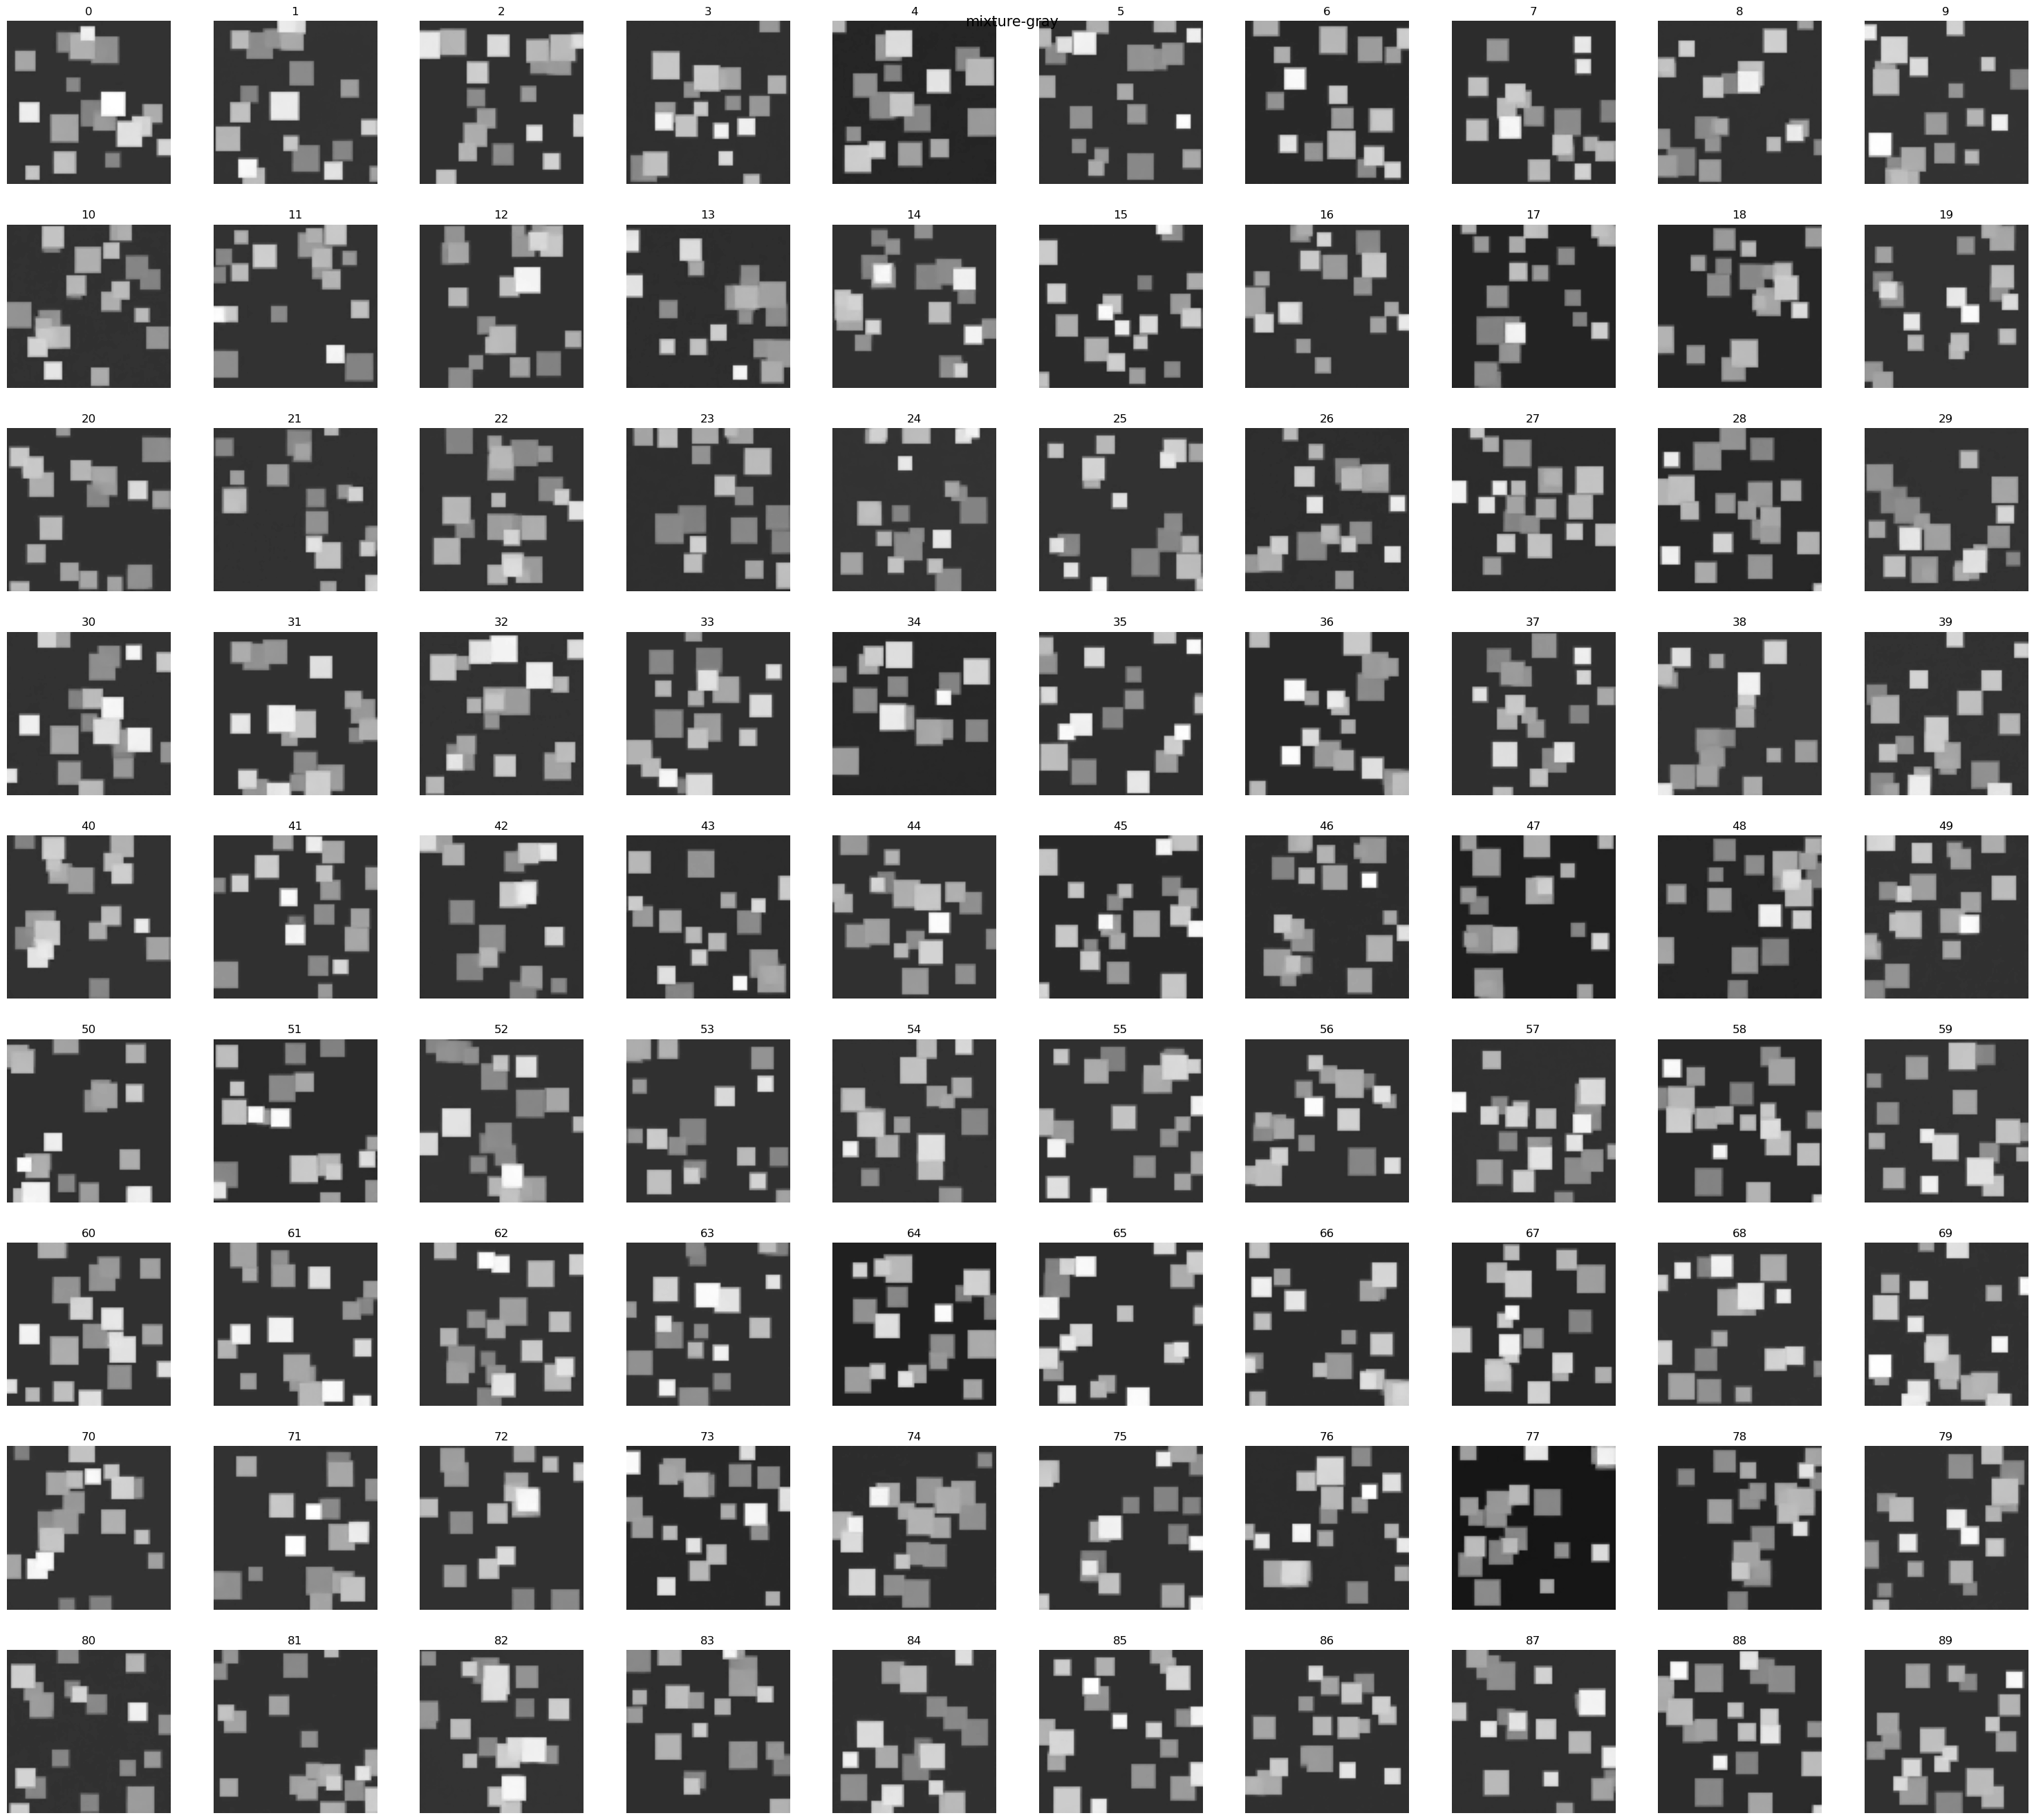

tensor(0.3153, device='cuda:0')


In [18]:
print('fixed_h=', fixed_h, ' sig_L= ',sig_L, ' h0=', h0, ' beta=',beta, ' seed=', seed, ' group=', group)
show_im_set(all_samples[group], n_columns=10, label=group, vmin=0, vmax = 1)

print(all_samples[group].mean())

fixed_h= True  sig_L=  0.1  h0= 0.01  beta= 0.02  seed= 0  group= mixture-gray


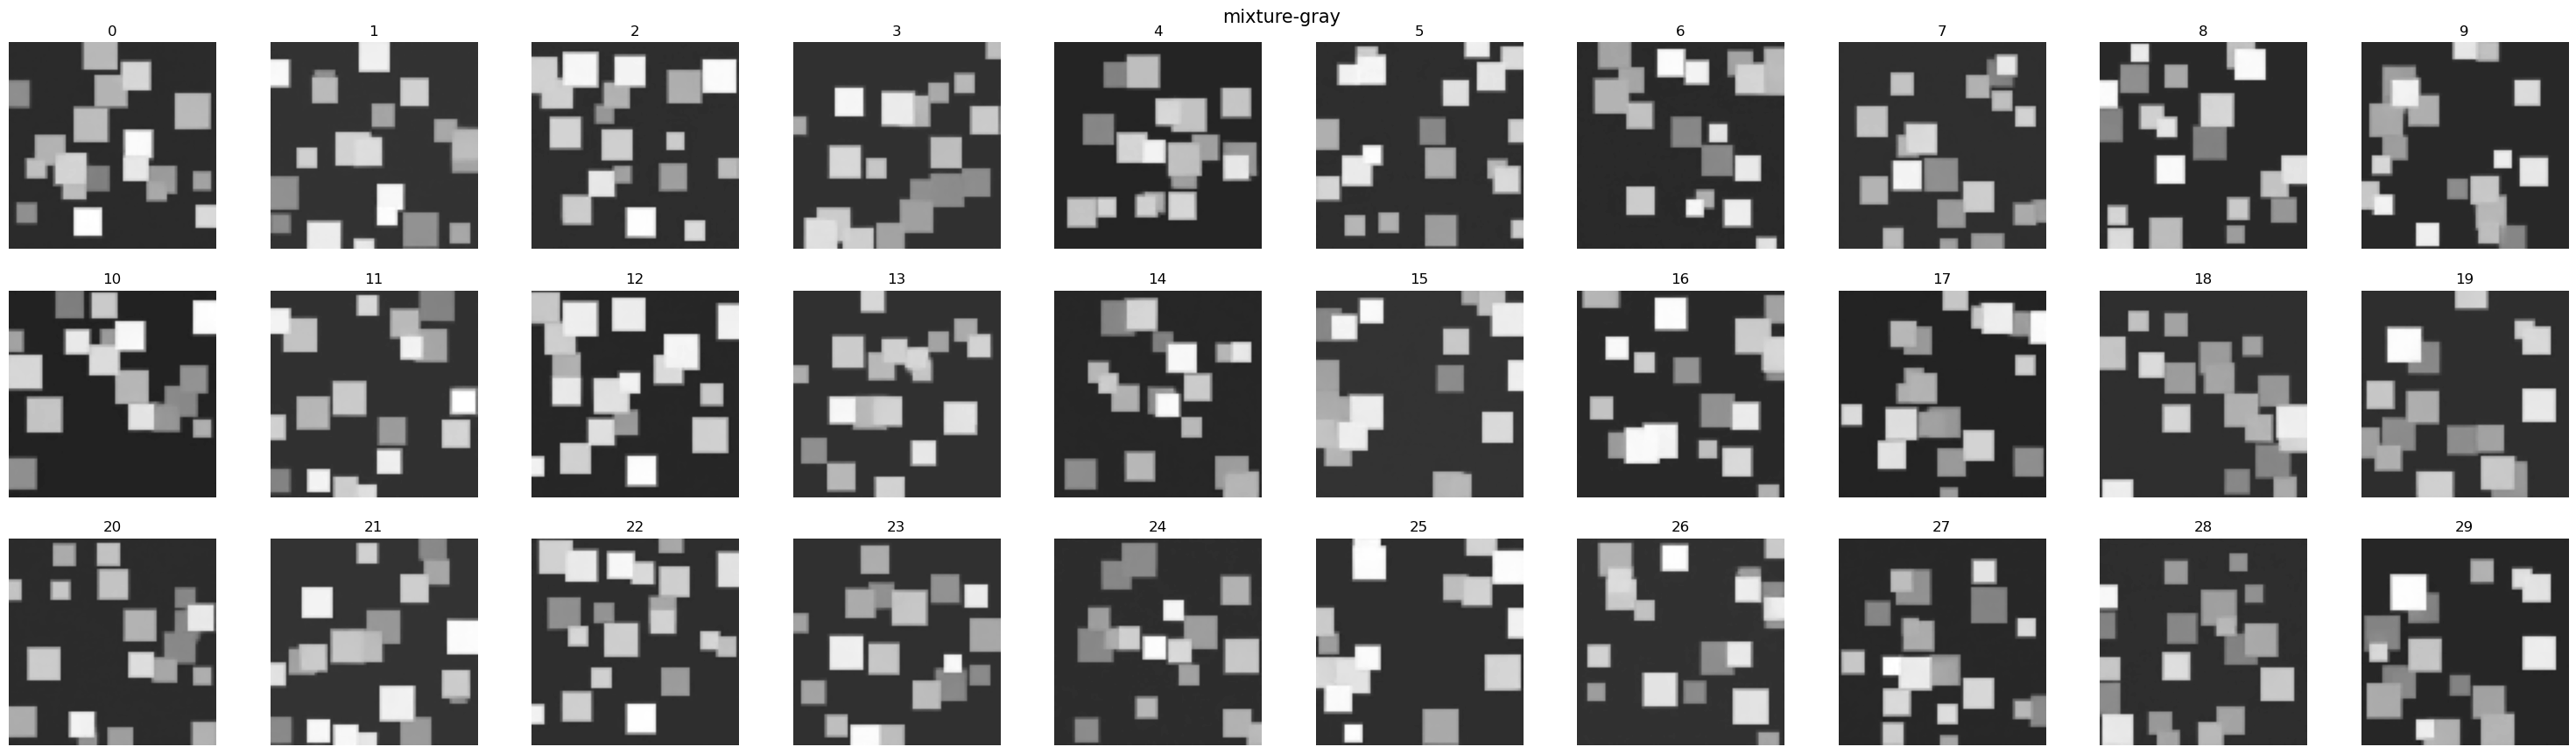

tensor(0.3413, device='cuda:0')


In [62]:
print('fixed_h=', fixed_h, ' sig_L= ',sig_L, ' h0=', h0, ' beta=',beta, ' seed=', seed, ' group=', group)
show_im_set(all_samples[group], n_columns=10, label=group, vmin=0, vmax = 1)

print(all_samples[group].mean())

fixed_h= True  sig_L=  0.1  h0= 0.01  beta= 0.1  seed= 0  group= mixture-gray


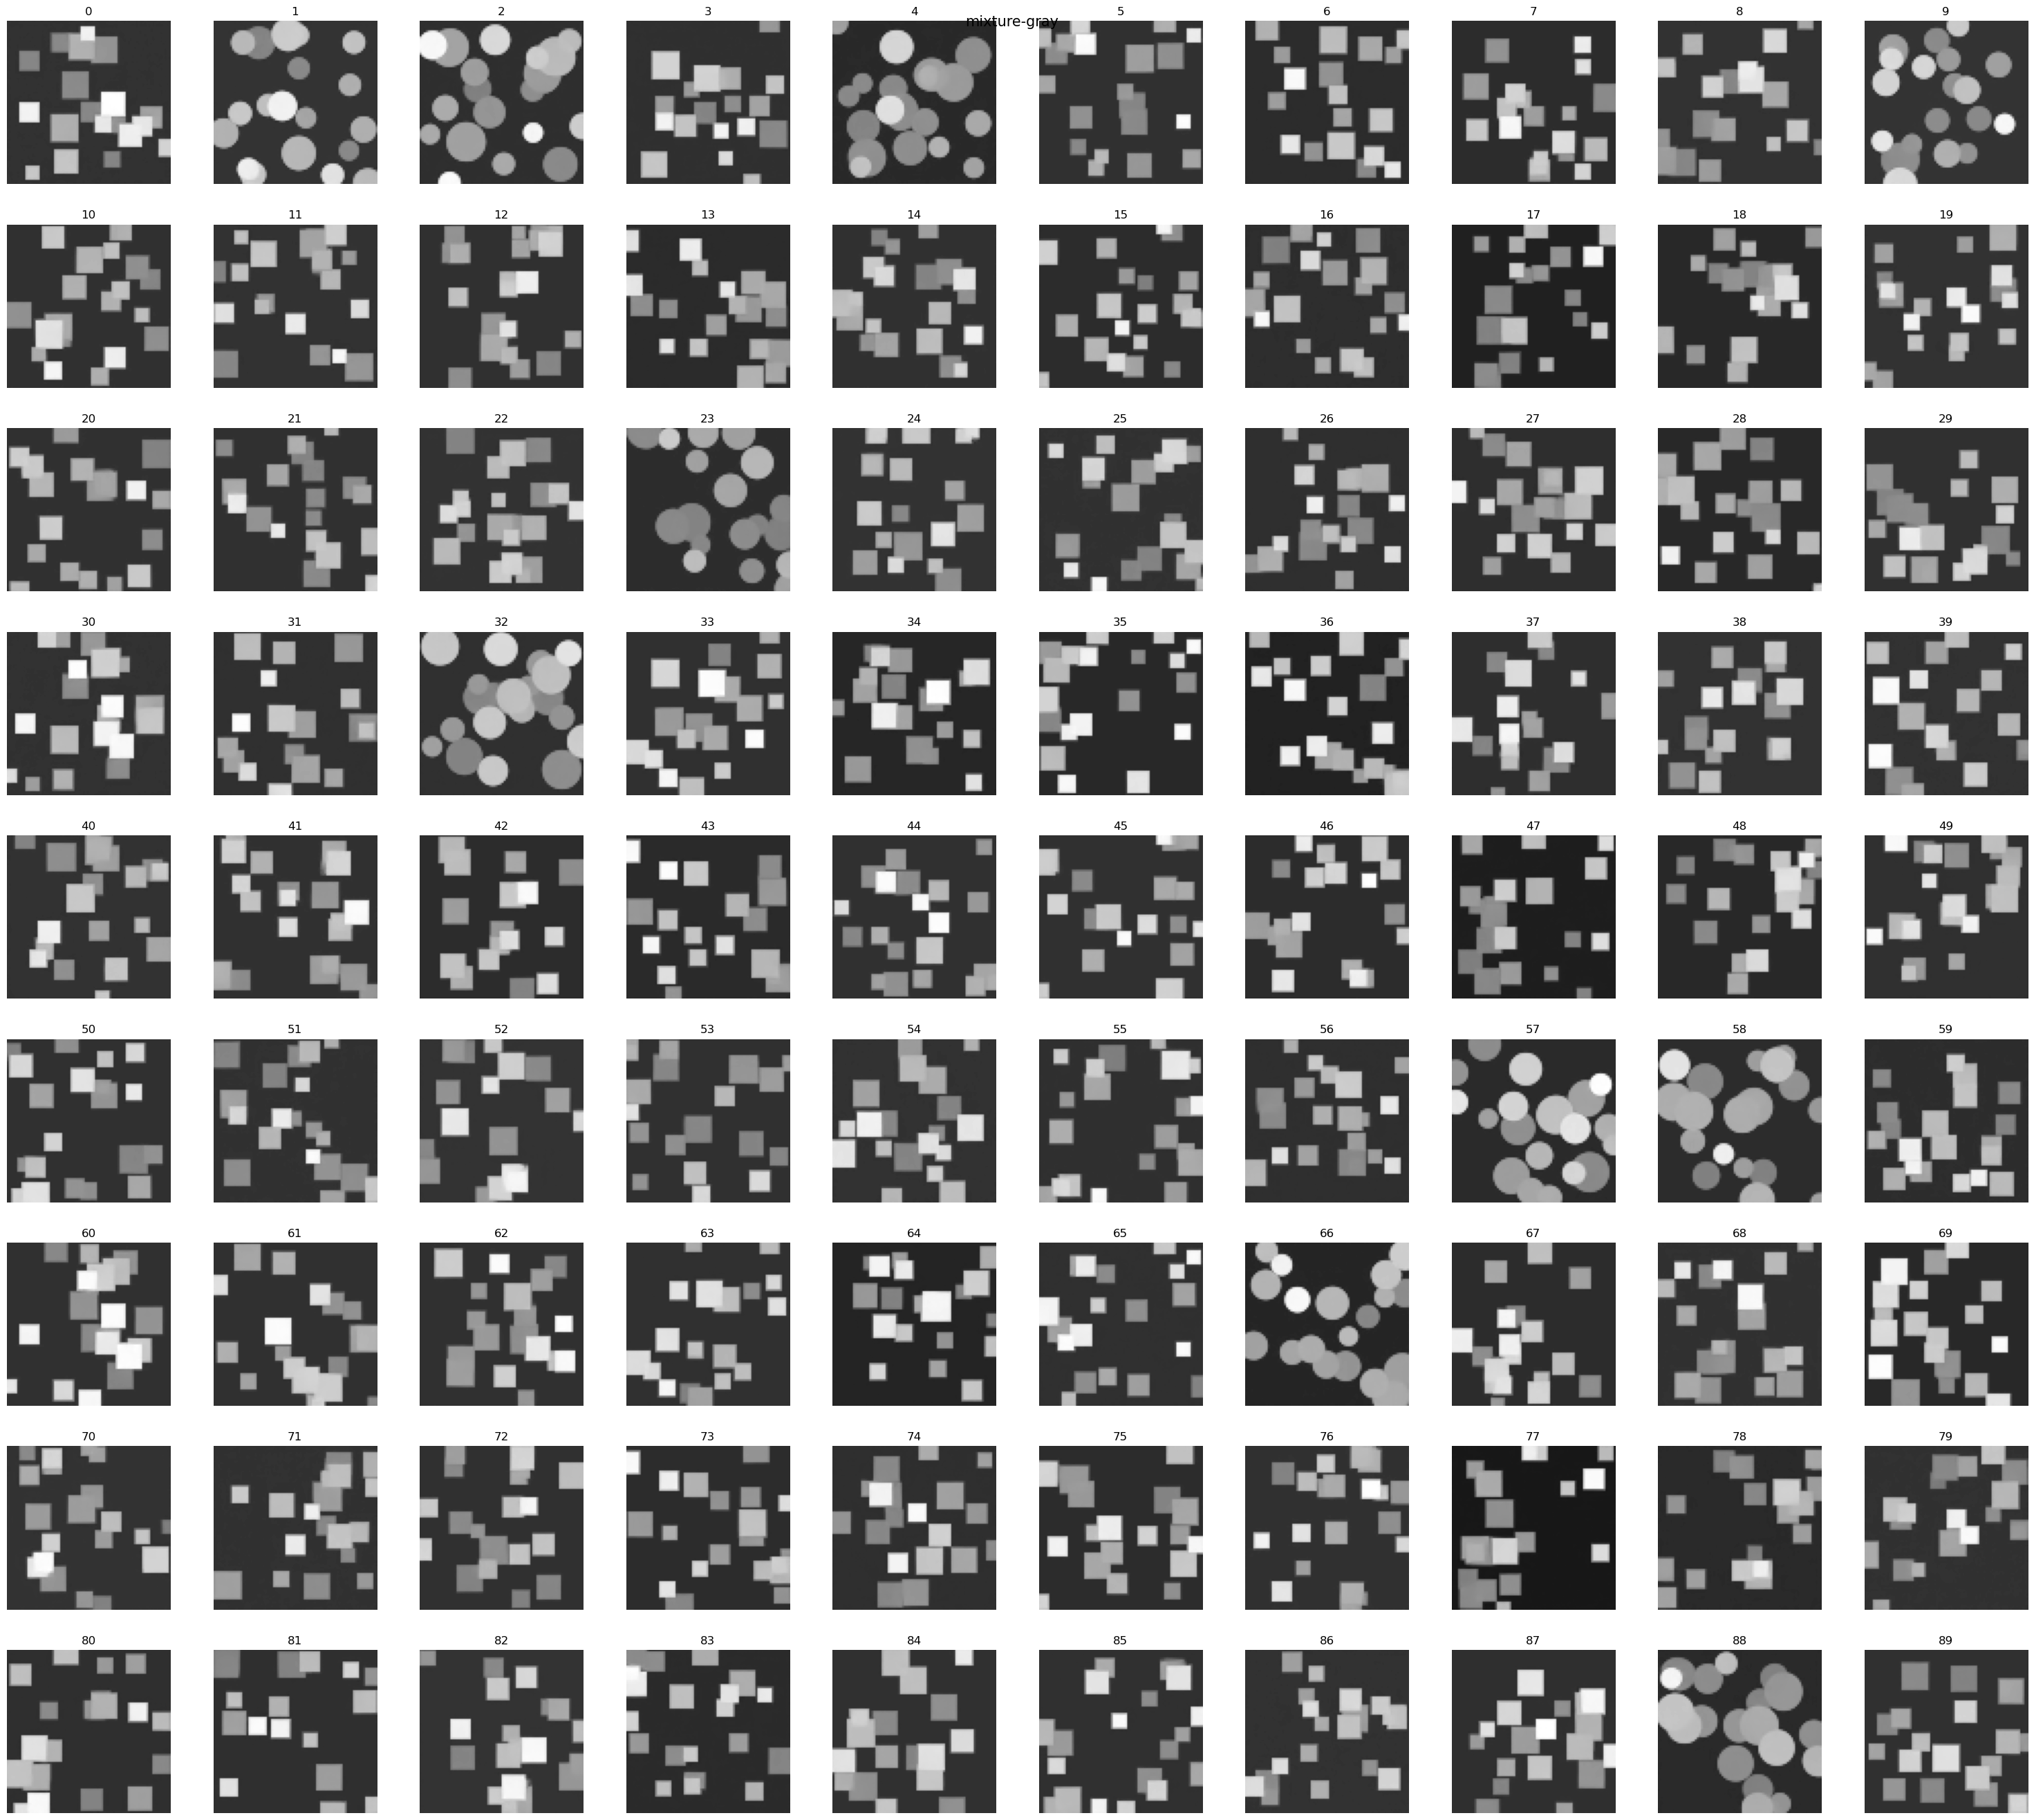

tensor(0.3327, device='cuda:0')


In [50]:
print('fixed_h=', fixed_h, ' sig_L= ',sig_L, ' h0=', h0, ' beta=',beta, ' seed=', seed, ' group=', group)
show_im_set(all_samples[group], n_columns=10, label=group, vmin=0, vmax = 1)

print(all_samples[group].mean())

fixed_h= True  sig_L=  0.1  h0= 0.01  beta= 0.1  seed= 0


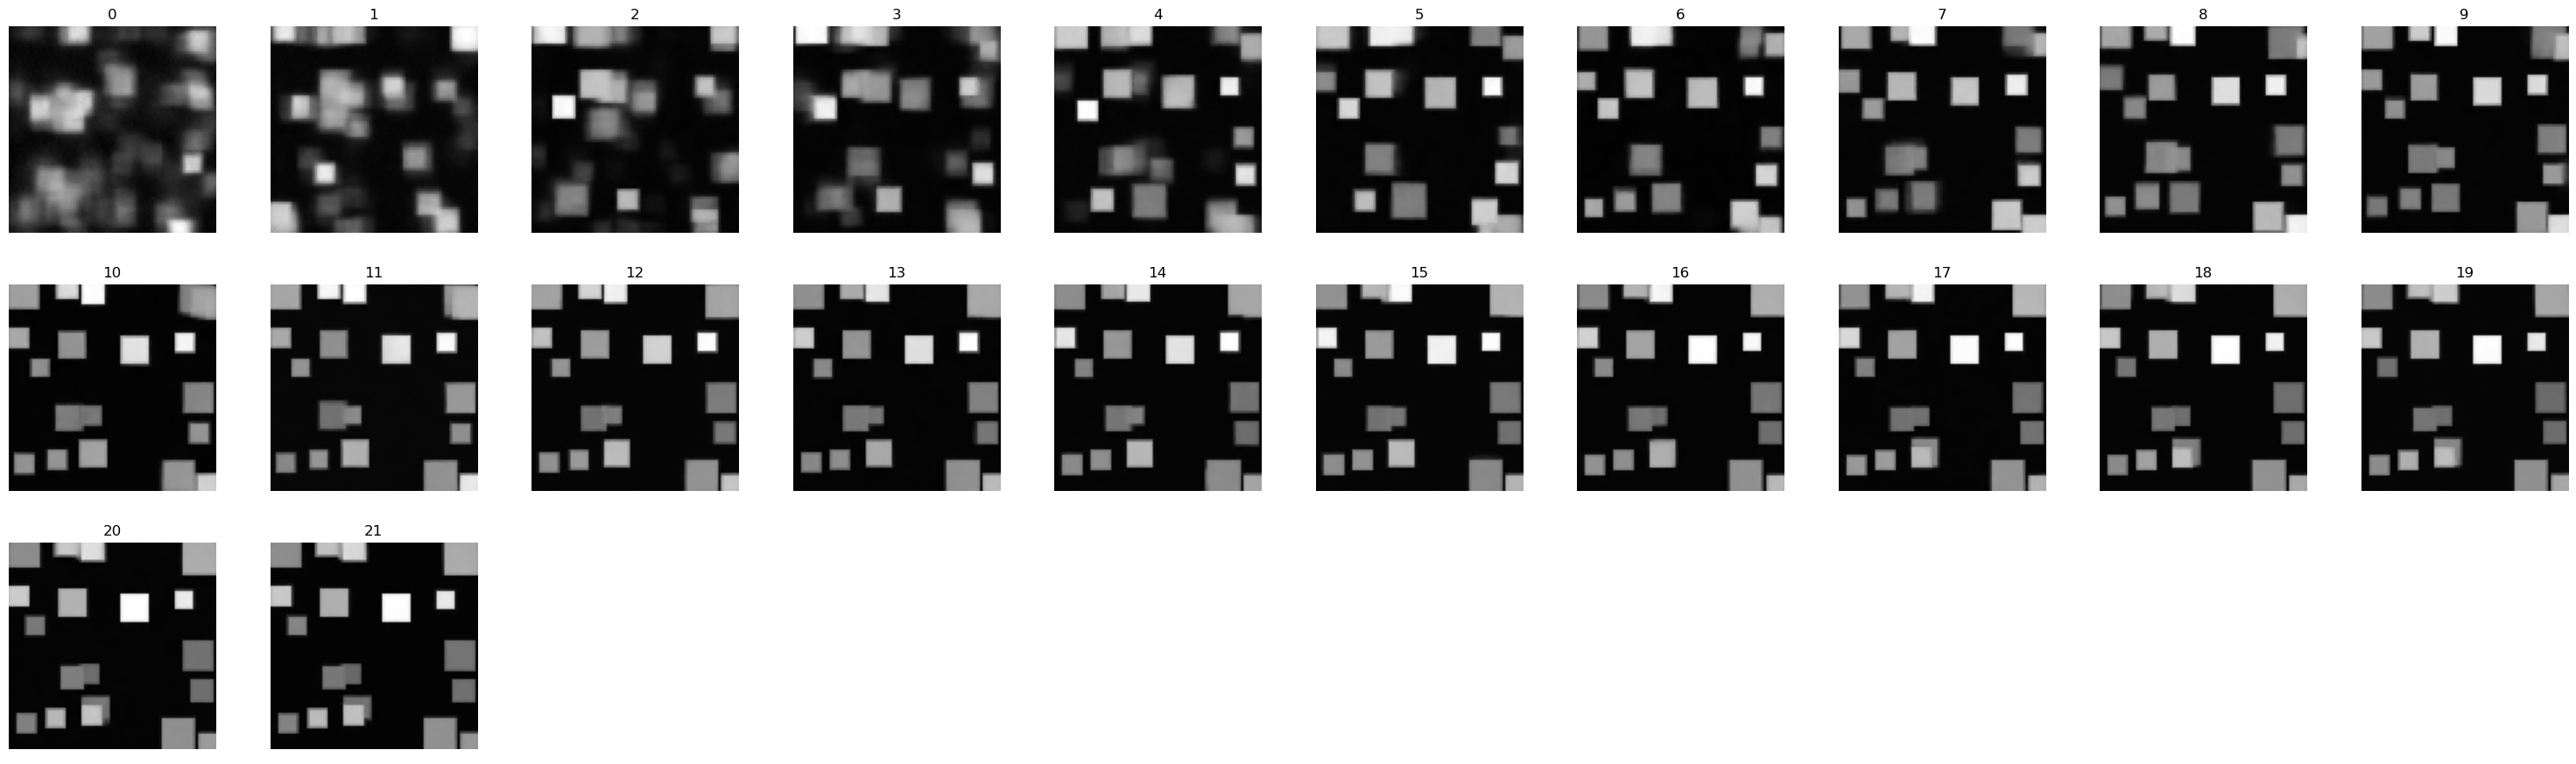

In [24]:
im_n = 23
print('fixed_h=', fixed_h, ' sig_L= ',sig_L, ' h0=', h0, ' beta=',beta, ' seed=', seed)
show_im_set(traj_projections(torch.stack(interm_Ys)[:,im_n], denoisers[group], x_cond=None), n_columns=10)

Most decorrelated images at different noise levels accoring to block:  mid


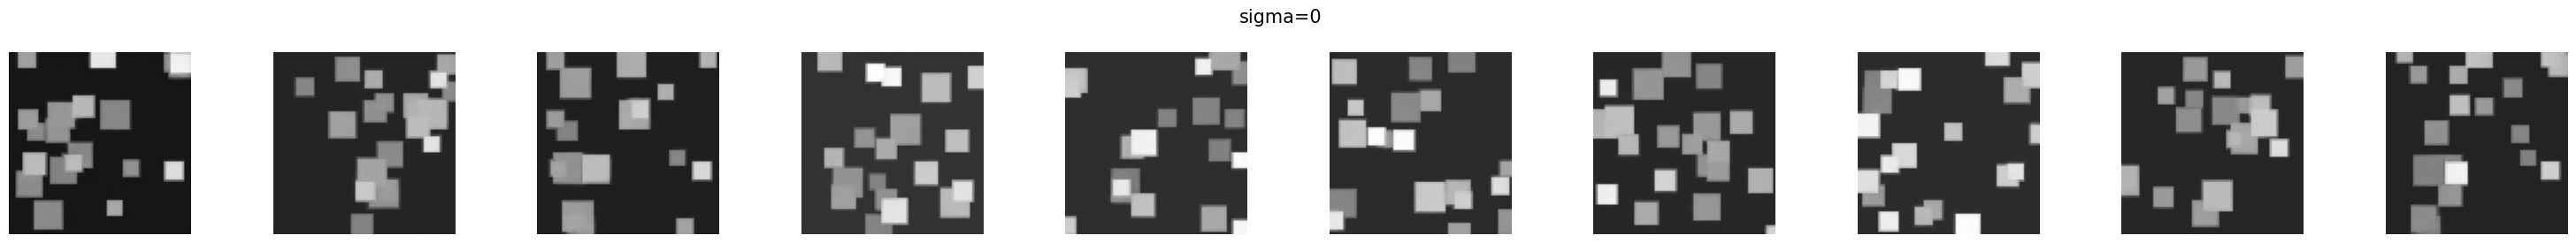

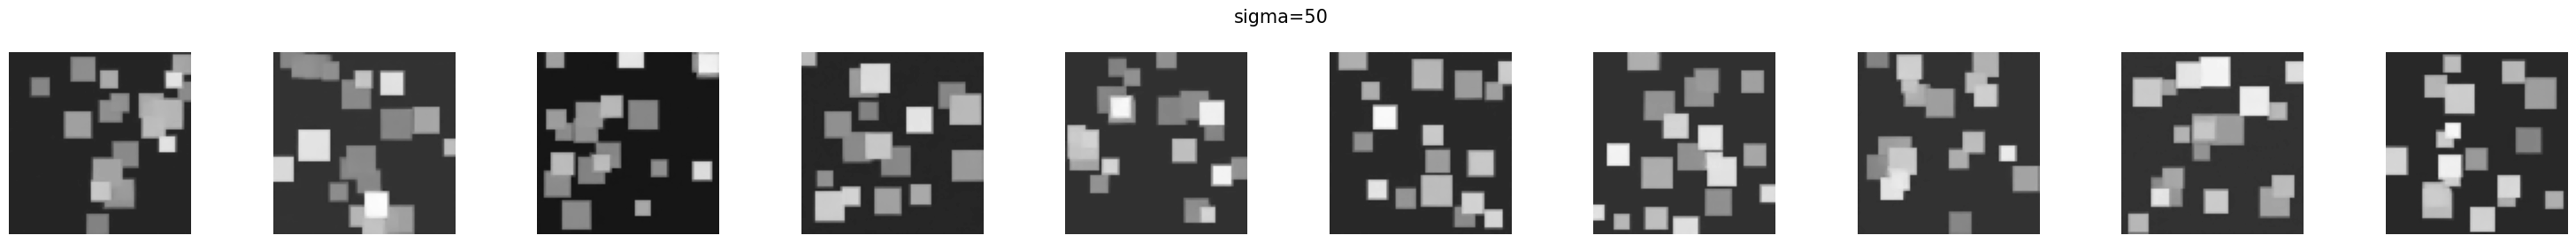

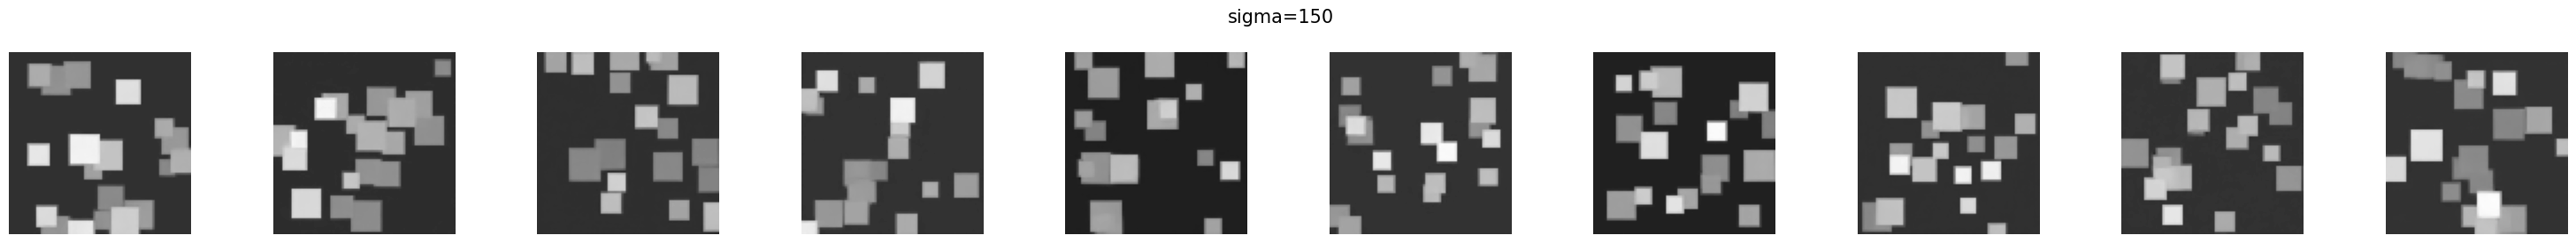

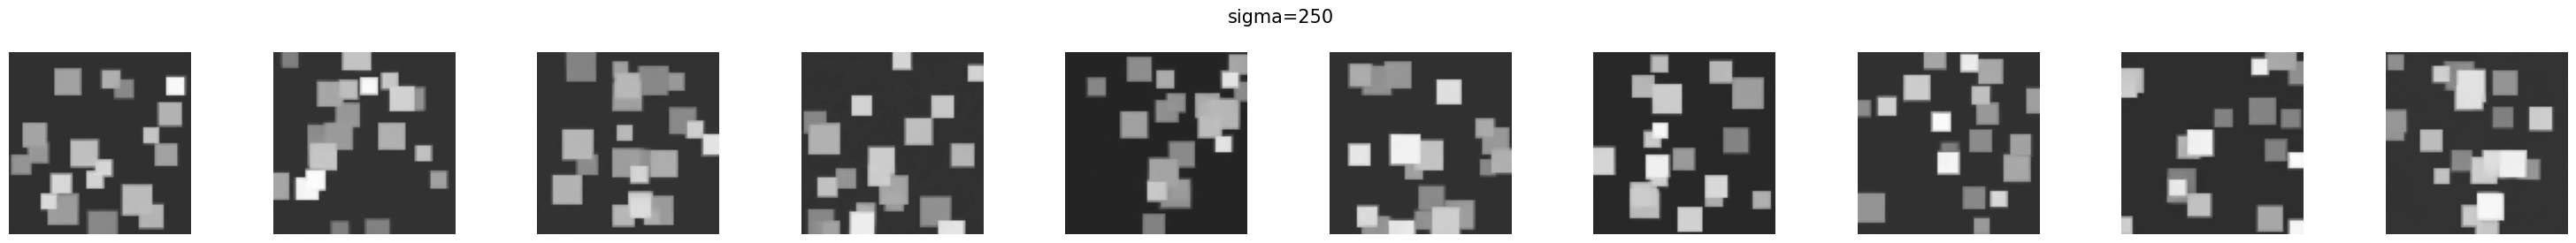

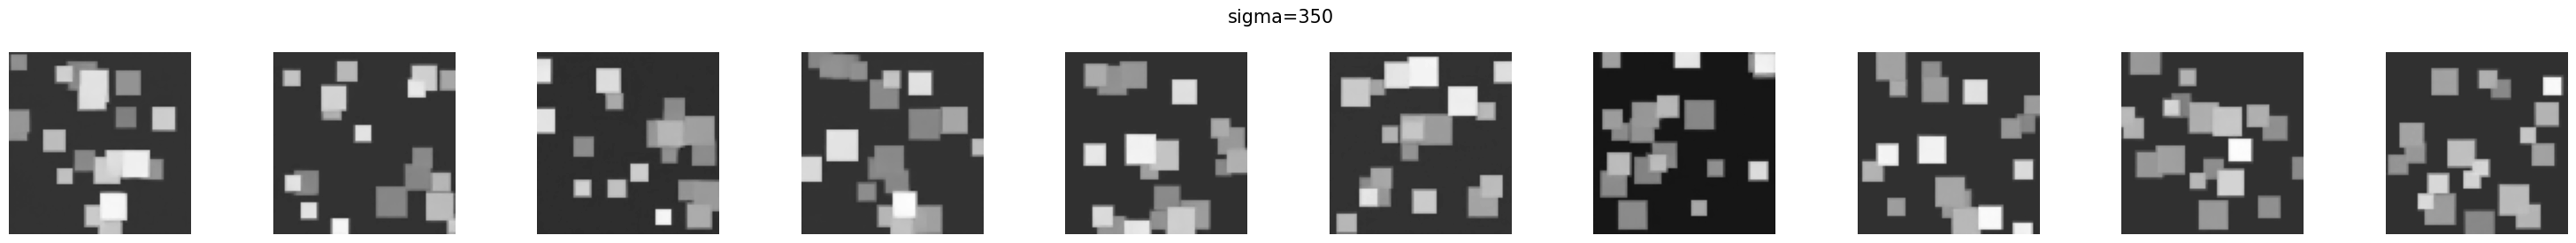

In [20]:
group = 'mixture-gray'
block = 3
im_cond = all_samples['mixture-gray']
print('Most decorrelated images at different noise levels accoring to block: ' , blocks[block])
for sig in [0, 50,150,250,350]:
    phi_1 = get_channel_means(denoisers[group], 
                      add_noise_torch(im_cond.to(device), sig, device=device)[0],
                      device,average_phi=False,with_params=True, return_activations=False)
    
    cov = torch.corrcoef(phi_1[block].squeeze() ).cpu()       
    
    idx = cov.sum(dim = 0).sort()[1]
    # show_im_set(im_cond[idx], n_columns=20, sub_labels= phi_1[block][idx].norm(dim = 1).cpu().squeeze().numpy() ) 
    show_im_set(im_cond[idx][0:10], n_columns=10, sub_labels= ['']* im_cond.shape[0] , label='sigma='+ str(sig), vmin=0, vmax = 1) 


Most decorrelated images across different blocks at noise level:  150


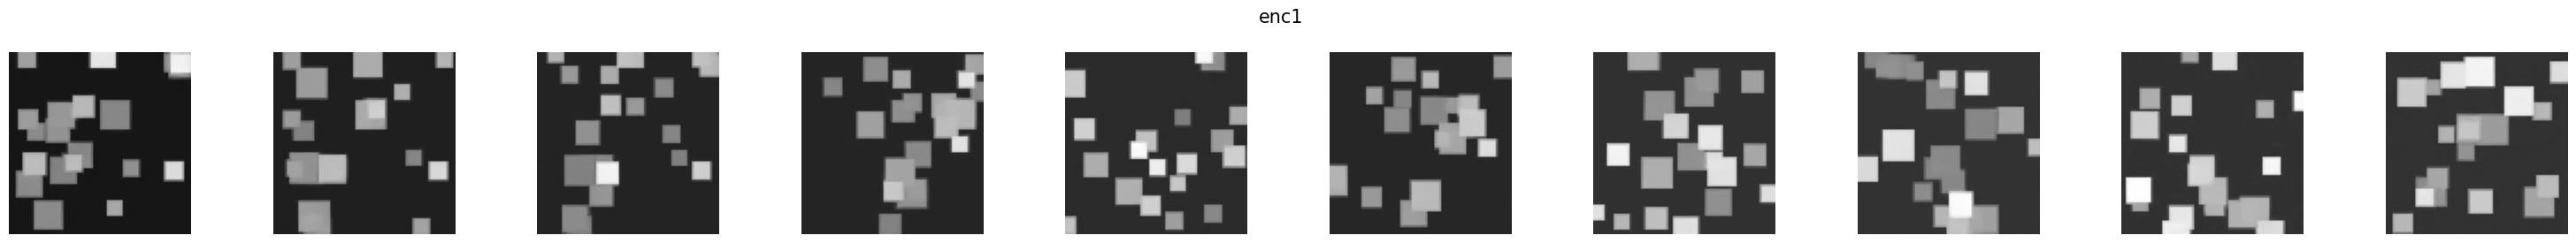

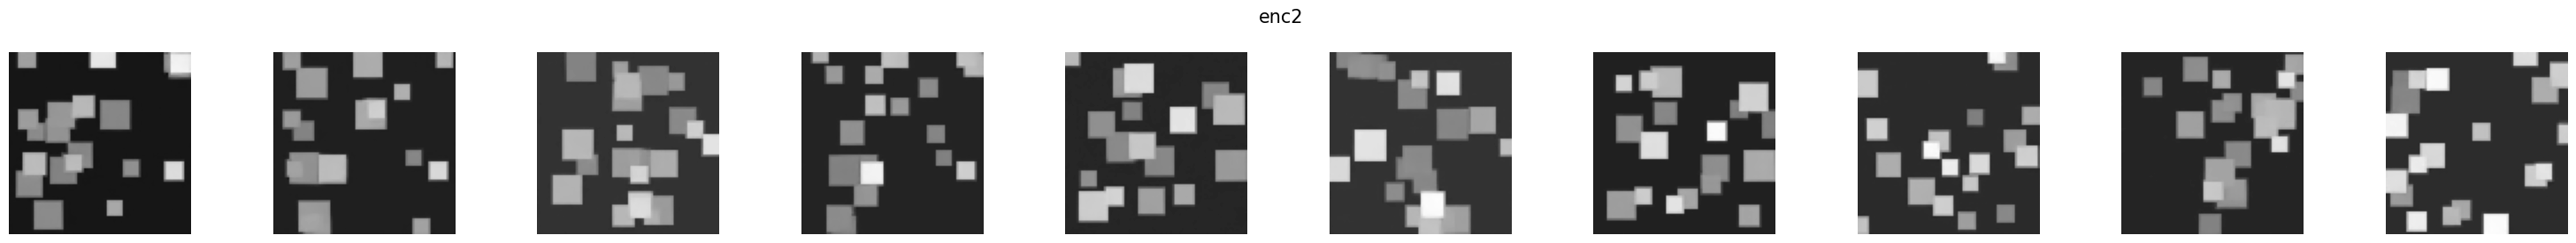

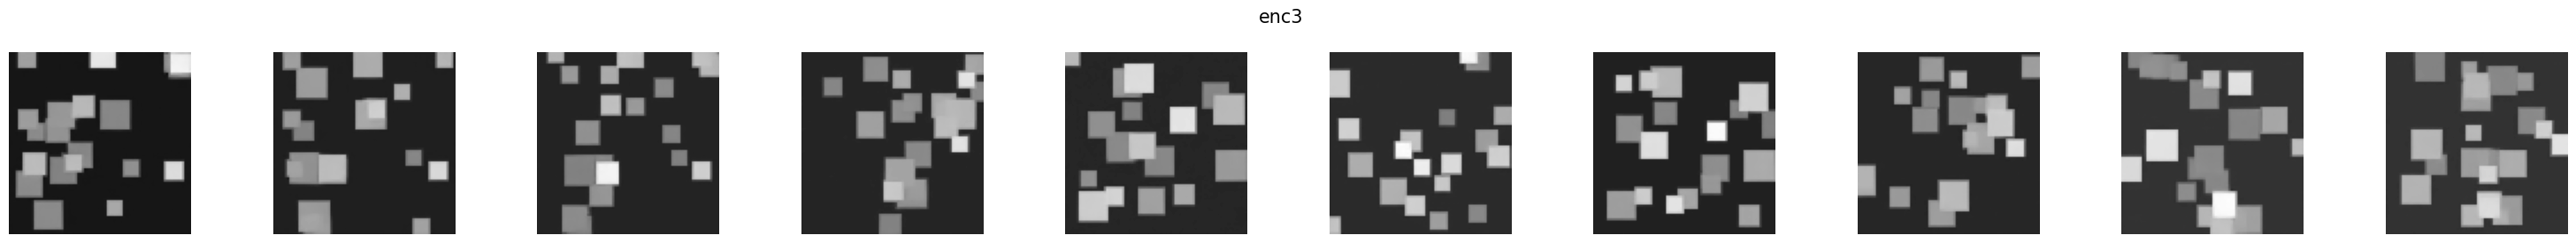

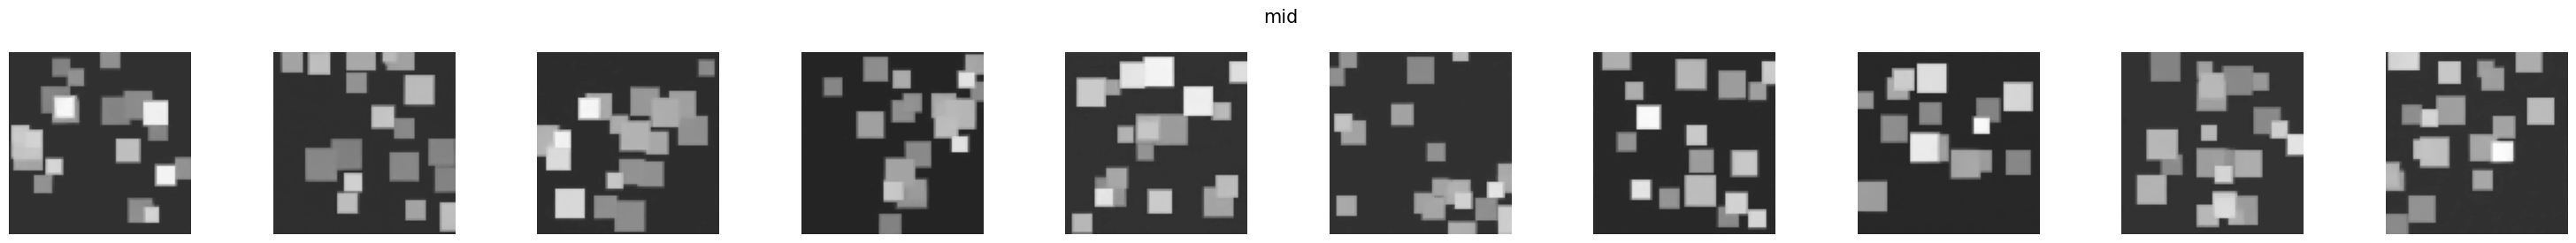

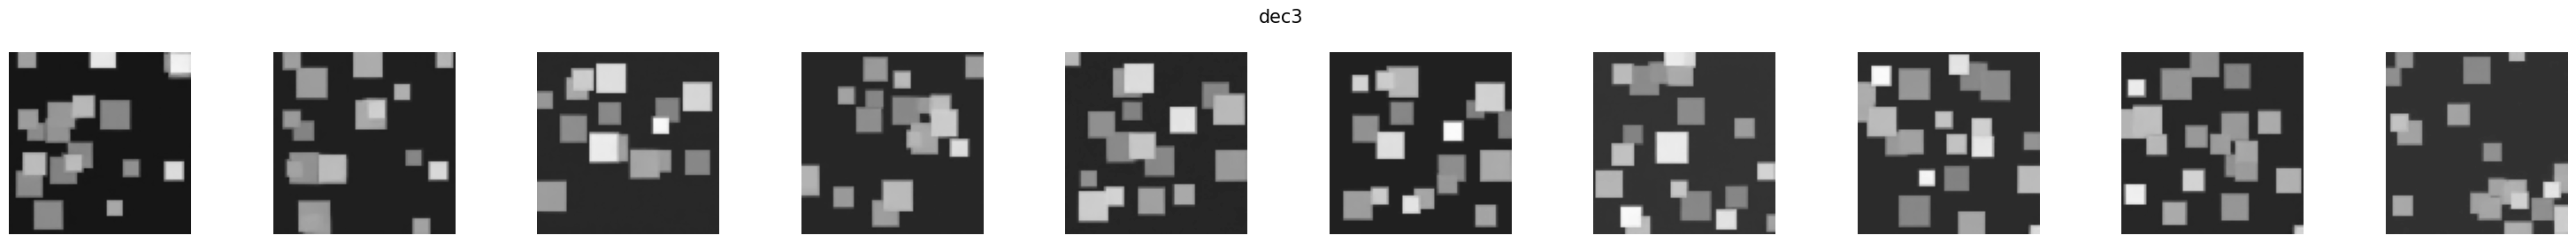

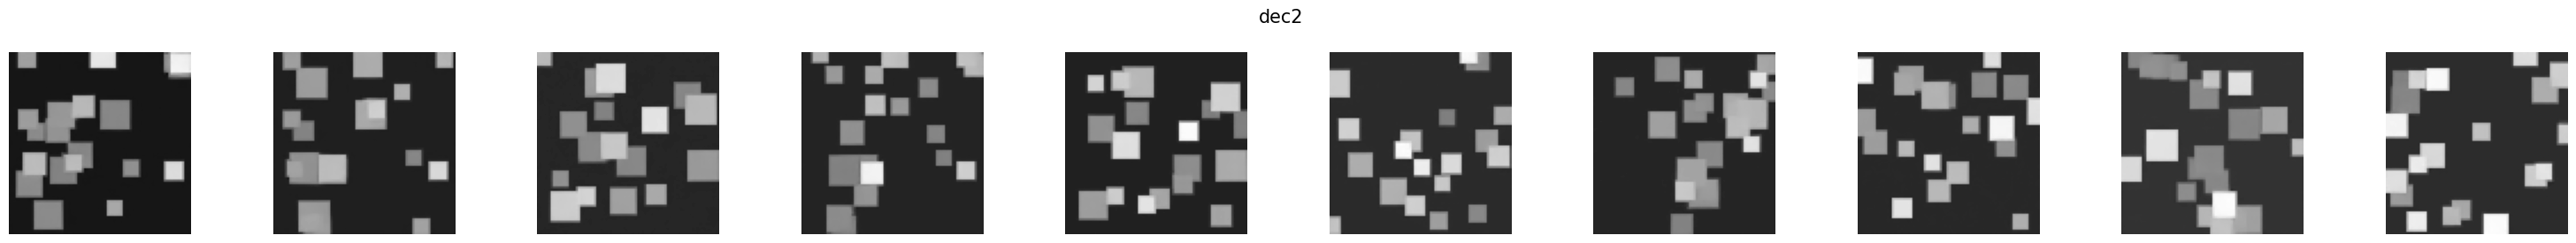

In [21]:
group = 'mixture-gray'
im_cond = all_samples['mixture-gray']
sig = 150
phi_1 = get_channel_means(denoisers[group], 
                      add_noise_torch(im_cond.to(device), sig, device=device)[0],
                      device,average_phi=False,with_params=True, return_activations=False)
print('Most decorrelated images across different blocks at noise level: ' , sig)
for block in range(len(blocks)):
    cov = torch.corrcoef(phi_1[block].squeeze() ).cpu()           
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(im_cond[idx][0:10], n_columns=10, sub_labels= ['']* im_cond.shape[0] , label=blocks[block],vmin=0, vmax = 1) 

# Synthesis from conditional model

In [26]:

ids_cond = [0,1]


In [27]:
groups

dict_keys(['mixture-gray', 'conditional-gray'])

## Batch synthesis

In [28]:

fixed_h = True
sig_L=.1
h0=.01
beta=.1
###################
n_samples =5
group = 'conditional-gray'

K = 80
shift = 0
seed = 0
freq =100
all_samples = {}
all_interm_Ys = {}
all_init = []


im_n = 0
for id in ids_cond: 
    if 'color' in group.split('-'):
        phi = get_channel_means(denoisers[group], train_sets[id], device, average_phi=True, with_params=False)
        n_channels=3        
    else: 
        phi = get_channel_means(denoisers[group], train_sets[id].mean(dim=1, keepdim=True), device, average_phi=True, with_params=False)
        n_channels=1
        
    print('------------ class id : ', id )
    start_time_total = time.time()    
    torch.manual_seed(seed )
    if 'color' in group.split('-'):
        init_im = dist_mean.to(device) +torch.randn(n_samples,n_channels,K,K, device = device).to(device)
    else: 
        init_im = dist_mean.mean(dim=0, keepdim=True).to(device)  +torch.randn(n_samples,n_channels,K,K, device = device).to(device)
        
    sample, interm_Ys,_, _ = batch_conditional_synthesis(denoisers[group], 
                                                            x_c = phi, 
                                                            average_phi=False ,
                                                            init_im =init_im,
                                                            sig_0=1, 
                                                            sig_L=sig_L, 
                                                            h0=h0 , 
                                                            beta=beta , 
                                                            freq=freq,
                                                            device=device, 
                                                            fixed_h = fixed_h,
                                                            max_T=10000, 
                                                            seed=seed, 
                                                            output_size=(n_samples,n_channels,K,K))

    print("--- %s seconds ---" % (time.time() - start_time_total))
        
    all_samples[id] = sample.detach()
    all_interm_Ys[id] = interm_Ys


------------ class id :  0
----------------------------- 100
sigma  0.7485845685005188
mean  0.3244740068912506
----------------------------- 200
sigma  0.6679733991622925
mean  0.32852330803871155
----------------------------- 300
sigma  0.6059671640396118
mean  0.3338203728199005
----------------------------- 400
sigma  0.5389417409896851
mean  0.3368144929409027
----------------------------- 500
sigma  0.4794909656047821
mean  0.34502822160720825
----------------------------- 600
sigma  0.4281263053417206
mean  0.3478066027164459
----------------------------- 700
sigma  0.37301260232925415
mean  0.35178589820861816
----------------------------- 800
sigma  0.33240872621536255
mean  0.35901960730552673
----------------------------- 900
sigma  0.2951827645301819
mean  0.36049824953079224
----------------------------- 1000
sigma  0.2622780501842499
mean  0.3635081350803375
----------------------------- 1100
sigma  0.23398390412330627
mean  0.3620374798774719
----------------------------

fixed_h: True  , sig_L: 0.1  , h0: 0.01  , beta: 0.1 , seed: 0
conditional-gray


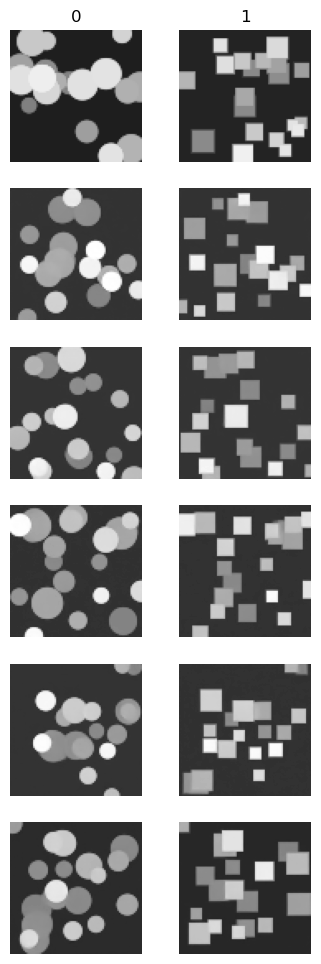

In [29]:
f, axs = plt.subplots( n_samples + 1 , len(ids_cond), figsize=(2*(len(ids_cond) ), 2*(n_samples+1)) )

for i in range(n_samples+1):
    for j in range(len(ids_cond)):
        axs[i,j].axis('off')
   
for i in range(len(ids_cond)): 
    for n in range(n_samples): 
        fig = axs[n+1, i].imshow(np.clip(all_samples[ids_cond[i]][n].permute(1,2,0).squeeze().cpu(), 0,1), 'gray', vmin=0, vmax=1)


for i in range(len(ids_cond)): 
    if 'color' in group.split('-'):
        fig = axs[0, i].imshow(train_sets[i][1].permute(1,2,0).squeeze().cpu(), 'gray')
    else: 
        fig = axs[0, i].imshow(train_sets[i][1].permute(1,2,0).mean(dim=-1, keepdim=True).cpu(), 'gray', vmin=0, vmax=1)
        
    axs[0,i].set_title(ids_cond[i])


print('fixed_h:',fixed_h ,' , sig_L:',sig_L ,' , h0:', h0 , ' , beta:', beta , ', seed:' ,seed)
print(group)


fixed_h: True  , sig_L: 0.1  , h0: 0.01  , beta: 0.1 , seed: 0 , denoiser: conditional-gray


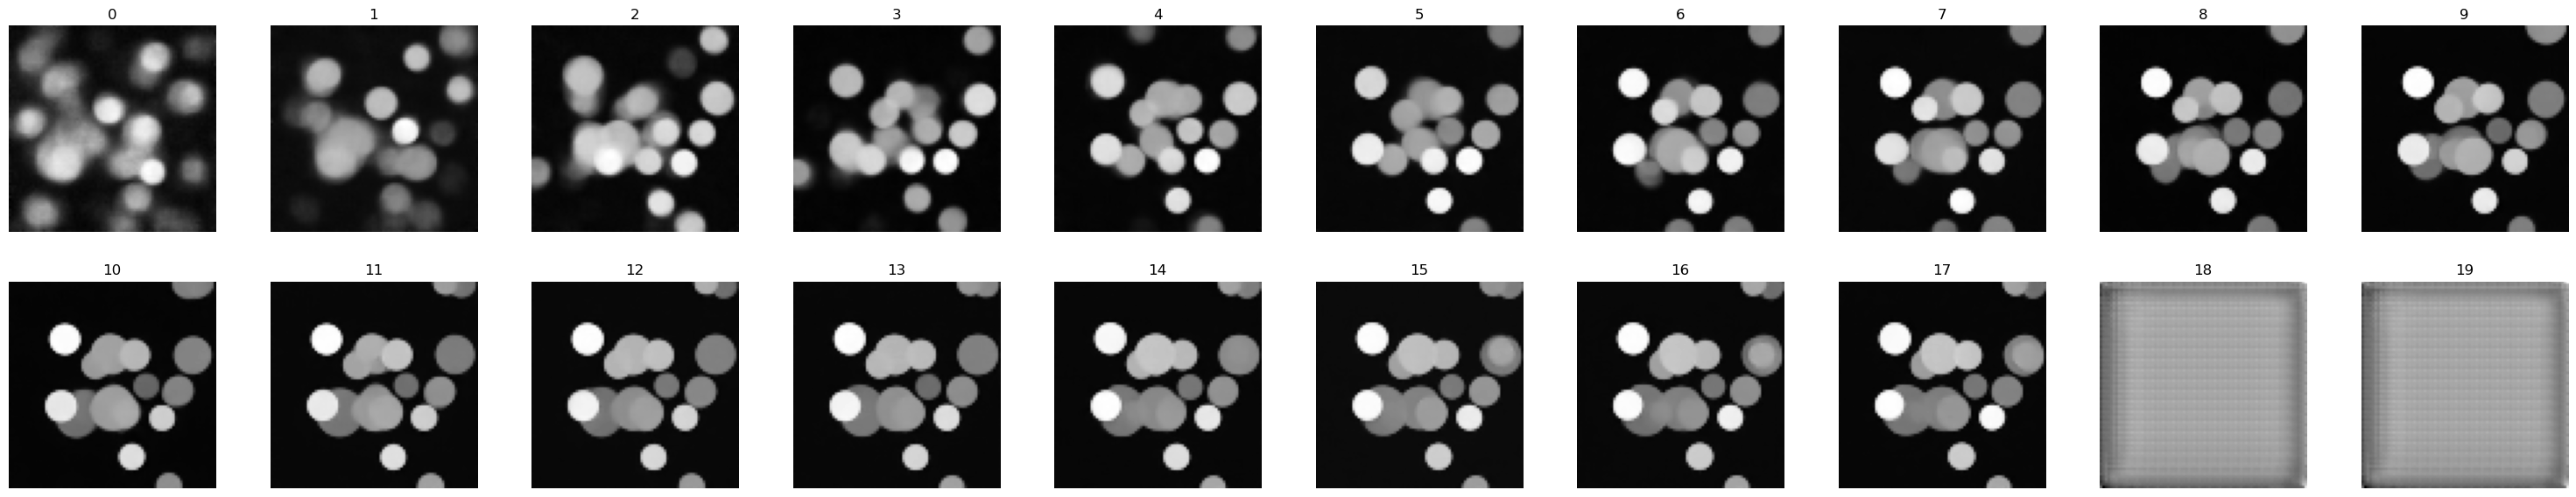

In [30]:
id = 0
im_n = 3

print('fixed_h:',fixed_h ,' , sig_L:',sig_L ,' , h0:', h0 , ' , beta:', beta , ', seed:' ,seed, ', denoiser:', group)
if 'color' in group.split('-'):
    phi = get_channel_means(denoisers[group], train_sets[id], device, average_phi=True, with_params=False)
else: 
    phi = get_channel_means(denoisers[group], train_sets[id].mean(dim=1, keepdim=True), device, average_phi=True, with_params=False)
    n_channels=1
show_im_set(traj_projections(torch.stack(all_interm_Ys[id])[:,im_n], denoisers[group], x_cond=phi), n_columns=10)

# synthesis by conditioning on out of distribution test image

In [51]:
test_ims , _=make_circles_squares_textures_dataset(set_size=100, num= 30)

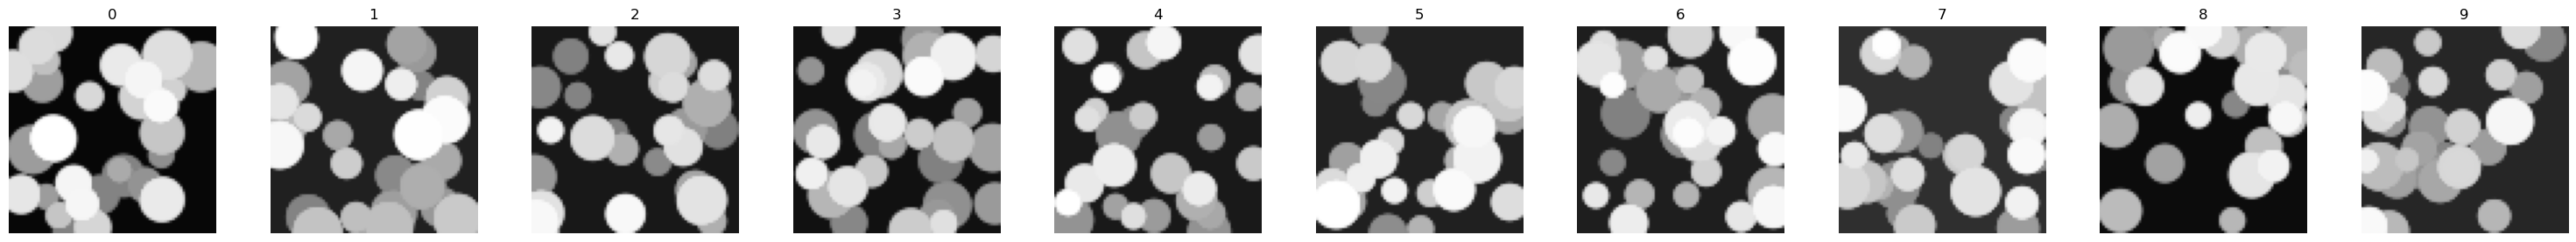

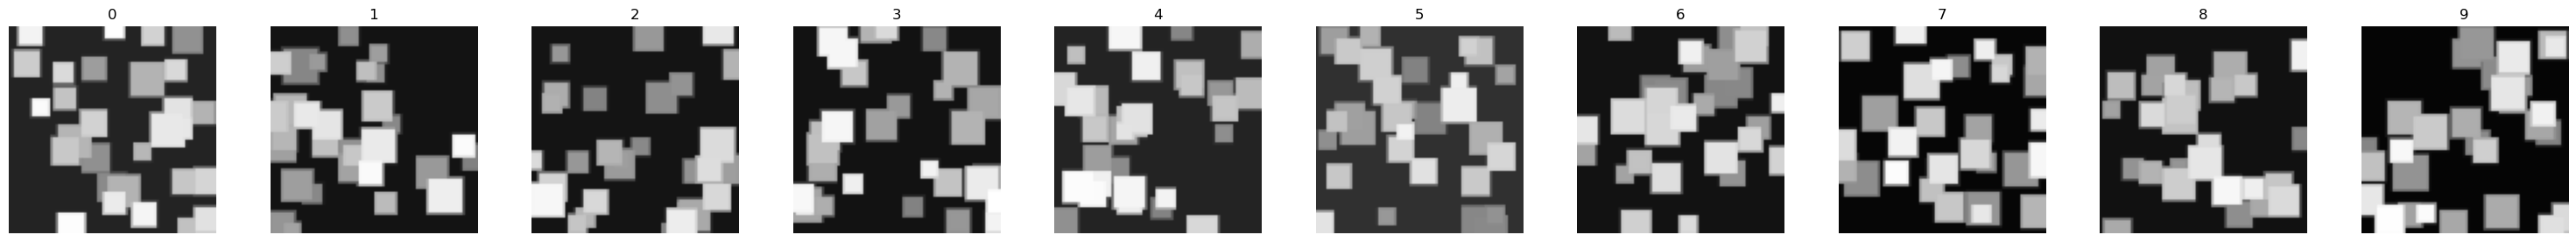

In [52]:
for i in range(len(test_ims)):
    show_im_set(test_ims[i][0:10], vmin=0, vmax = 1 , n_columns=10)


In [57]:

fixed_h = True
sig_L=.1
h0=.01
beta=.1
###################
n_samples =5
group = 'conditional-gray'

K = 160
shift = 0
seed = None
freq =100
all_samples = {}
all_interm_Ys = {}
all_init = []


im_n = 0
for id in range(len(test_ims)): 
    if 'color' in group.split('-'):
        phi = get_channel_means(denoisers[group], test_ims[id][0:100 ], device, average_phi=True, with_params=False)
        n_channels=3        
    else: 
        phi = get_channel_means(denoisers[group], test_ims[id][0:100].mean(dim=1, keepdim=True), device, average_phi=True, with_params=False)
        n_channels=1
        
    print('------------ class id : ', id )
    start_time_total = time.time()    
    if seed is not None:
        torch.manual_seed(seed )
    if 'color' in group.split('-'):
        init_im = dist_mean.to(device) +torch.randn(n_samples,n_channels,K,K, device = device).to(device)
    else: 
        init_im = dist_mean.mean(dim=0, keepdim=True).mean().to(device)  +torch.randn(n_samples,n_channels,K,K, device = device).to(device)
        
    sample, interm_Ys,_, _ = batch_conditional_synthesis(denoisers[group], 
                                                            x_c = phi, 
                                                            average_phi=False ,
                                                            init_im =init_im,
                                                            sig_0=1, 
                                                            sig_L=sig_L, 
                                                            h0=h0 , 
                                                            beta=beta , 
                                                            freq=freq,
                                                            device=device, 
                                                            fixed_h = fixed_h,
                                                            max_T=10000, 
                                                            seed=seed, 
                                                            output_size=(n_samples,n_channels,K,K))

    print("--- %s seconds ---" % (time.time() - start_time_total))
            
    all_samples[id] = sample.detach()
    all_interm_Ys[id] = interm_Ys
    


------------ class id :  0
----------------------------- 100
sigma  0.8702163100242615
mean  0.33029597997665405
----------------------------- 200
sigma  0.7699641585350037
mean  0.33667969703674316
----------------------------- 300
sigma  0.6813929080963135
mean  0.34423112869262695
----------------------------- 400
sigma  0.6017370223999023
mean  0.3514222800731659
----------------------------- 500
sigma  0.5351482629776001
mean  0.3556881248950958
----------------------------- 600
sigma  0.4722960591316223
mean  0.3607051372528076
----------------------------- 700
sigma  0.4177834689617157
mean  0.36222177743911743
----------------------------- 800
sigma  0.3713955283164978
mean  0.36315515637397766
----------------------------- 900
sigma  0.3283853530883789
mean  0.36603957414627075
----------------------------- 1000
sigma  0.290086567401886
mean  0.36822858452796936
----------------------------- 1100
sigma  0.2577795088291168
mean  0.3711395859718323
----------------------------- 

fixed_h: True  , sig_L: 0.1  , h0: 0.01  , beta: 0.1 , seed: None
conditional-gray


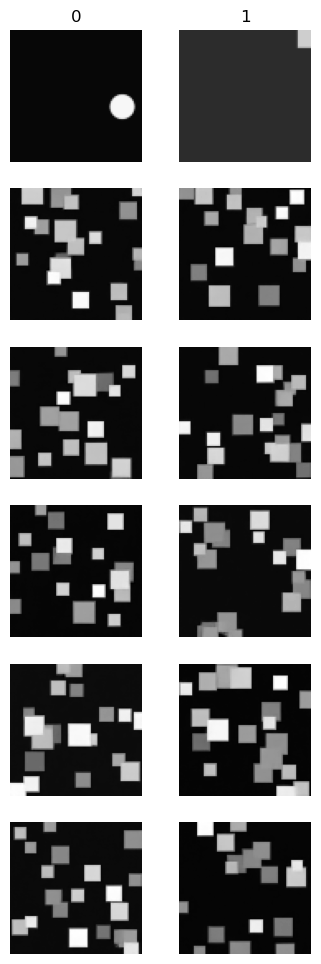

In [46]:
f, axs = plt.subplots( n_samples + 1 , len( all_samples), figsize=(2*(len( all_samples) ), 2*(n_samples+1)) )

for i in range(n_samples+1):
    for j in range(len( all_samples )):
        axs[i,j].axis('off')
   
for i in range(len(test_ims) ): 
    for n in range(n_samples): 
        fig = axs[n+1, i].imshow(np.clip(all_samples[i][n].permute(1,2,0).squeeze().cpu(), 0,1), 'gray')


for i in range(len(test_ims)): 
    if 'color' in group.split('-'):
        fig = axs[0, i].imshow(test_ims[i][1].permute(1,2,0).squeeze().cpu(), 'gray')
    else: 
        fig = axs[0, i].imshow(test_ims[i][1].permute(1,2,0).mean(dim=-1, keepdim=True).cpu(), 'gray', vmin=0, vmax=1)
        
    axs[0,i].set_title(i)


print('fixed_h:',fixed_h ,' , sig_L:',sig_L ,' , h0:', h0 , ' , beta:', beta , ', seed:' ,seed)
print(group)


fixed_h: True  , sig_L: 0.1  , h0: 0.01  , beta: 0.1 , seed: None
conditional-gray


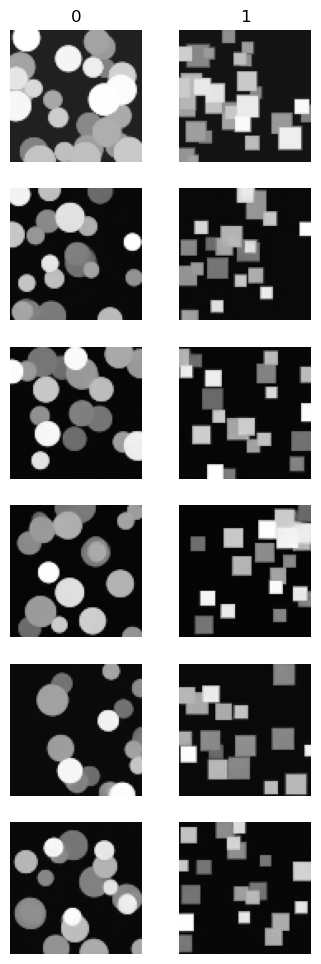

In [54]:
f, axs = plt.subplots( n_samples + 1 , len( all_samples), figsize=(2*(len( all_samples) ), 2*(n_samples+1)) )

for i in range(n_samples+1):
    for j in range(len( all_samples )):
        axs[i,j].axis('off')
   
for i in range(len(test_ims) ): 
    for n in range(n_samples): 
        fig = axs[n+1, i].imshow(np.clip(all_samples[i][n].permute(1,2,0).squeeze().cpu(), 0,1), 'gray')


for i in range(len(test_ims)): 
    if 'color' in group.split('-'):
        fig = axs[0, i].imshow(test_ims[i][1].permute(1,2,0).squeeze().cpu(), 'gray')
    else: 
        fig = axs[0, i].imshow(test_ims[i][1].permute(1,2,0).mean(dim=-1, keepdim=True).cpu(), 'gray', vmin=0, vmax=1)
        
    axs[0,i].set_title(i)


print('fixed_h:',fixed_h ,' , sig_L:',sig_L ,' , h0:', h0 , ' , beta:', beta , ', seed:' ,seed)
print(group)


fixed_h: True  , sig_L: 0.1  , h0: 0.01  , beta: 0.1 , seed: None , denoiser: conditional-gray


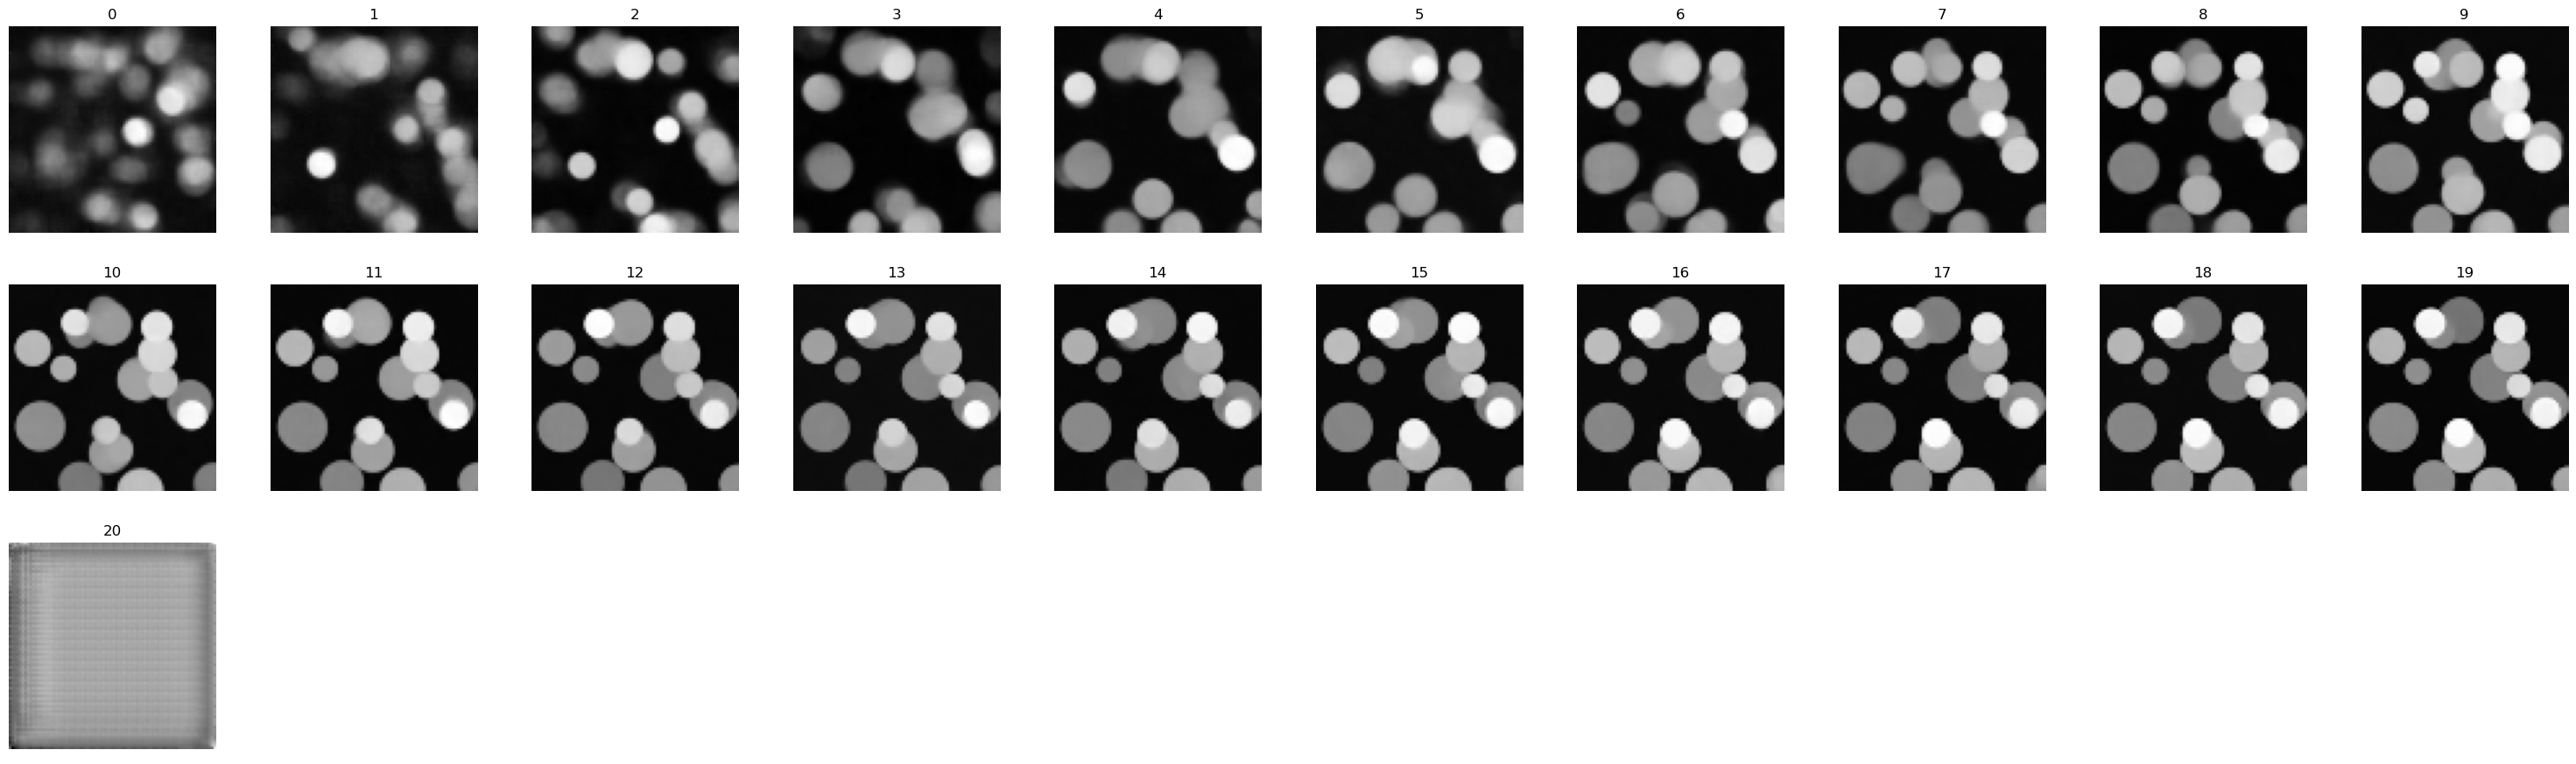

In [55]:
id = 0
im_n = 4
print('fixed_h:',fixed_h ,' , sig_L:',sig_L ,' , h0:', h0 , ' , beta:', beta , ', seed:' ,seed, ', denoiser:', group)
if 'color' in group.split('-'):
    phi = get_channel_means(denoisers[group], test_ims[id][0:100], device, average_phi=True, with_params=False)
else: 
    phi = get_channel_means(denoisers[group], test_ims[id][0:100].mean(dim=1, keepdim=True), device, average_phi=True, with_params=False)
    n_channels=1
    
show_im_set(traj_projections(torch.stack(all_interm_Ys[id])[:,im_n], denoisers[group], x_cond=phi), n_columns=10)

fixed_h: True  , sig_L: 0.1  , h0: 0.01  , beta: 0.1 , seed: None
conditional-gray


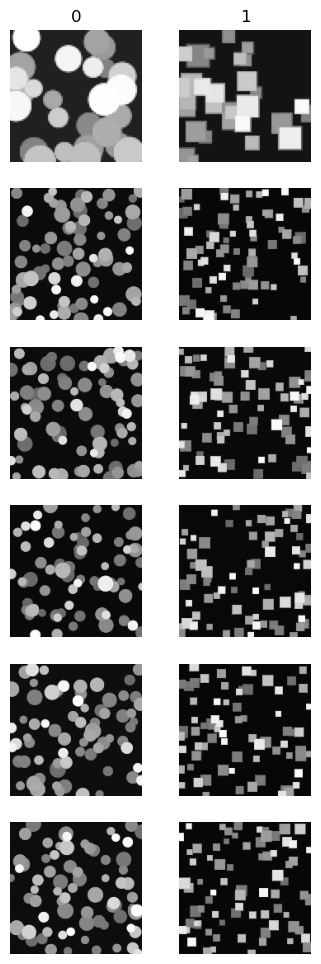

In [58]:
f, axs = plt.subplots( n_samples + 1 , len( all_samples), figsize=(2*(len( all_samples) ), 2*(n_samples+1)) )

for i in range(n_samples+1):
    for j in range(len( all_samples )):
        axs[i,j].axis('off')
   
for i in range(len(test_ims) ): 
    for n in range(n_samples): 
        fig = axs[n+1, i].imshow(np.clip(all_samples[i][n].permute(1,2,0).squeeze().cpu(), 0,1), 'gray')


for i in range(len(test_ims)): 
    if 'color' in group.split('-'):
        fig = axs[0, i].imshow(test_ims[i][1].permute(1,2,0).squeeze().cpu(), 'gray')
    else: 
        fig = axs[0, i].imshow(test_ims[i][1].permute(1,2,0).mean(dim=-1, keepdim=True).cpu(), 'gray', vmin=0, vmax=1)
        
    axs[0,i].set_title(i)


print('fixed_h:',fixed_h ,' , sig_L:',sig_L ,' , h0:', h0 , ' , beta:', beta , ', seed:' ,seed)
print(group)


# conditional synthesis from mixture model 

In [16]:
def initialize_network(network_name, args):
    '''
    Function to dynamically initialize a neural network by class name
    '''
    if network_name in globals() and issubclass(globals()[network_name], nn.Module):
        return globals()[network_name](args)
    else:
        raise ValueError(f"Network {network_name} not found or not a subclass of nn.Module")

        
def load_learned_model(folder_path, print_args=False): 
    '''
    Loads dictionary of all args used to define the model for training and then loads the saved trained model with the specified parameters.
    This can only be used if the network parameters were saved in advanced.
    '''
    with (open(folder_path +'exp_arguments.pkl' , "rb")) as openfile:
        arguments = pickle.load(openfile)    
    
    if print_args: 
        print('*************** saved arguments:*************')
        for key,v in arguments.items(): 
            print(key, v)
    parser = argparse.ArgumentParser(description='set CNN args')

    for k,v in arguments.items(): 
        parser.add_argument('--' + k, default=v)
    args = parser.parse_args('')
    
    args.arch_name = 'UNet_conditional_mean_matching'
    model = initialize_network(args.arch_name, args)
    if torch.cuda.is_available():
        model = model.cuda()
        
    model = read_trained_params(model, folder_path + '/model.pt')
    print('******************************************************')
    print('number of parameters is ' , sum(p.numel() for p in model.parameters() if p.requires_grad))

    model.eval()
    print('train mode:', model.training )
    return model      


##################################################################################################
def read_trained_params(model, path): 
    '''reads parametres of saved models into an initialized network'''
    if torch.cuda.is_available():
        learned_params =torch.load(path, weights_only=True)
    else:
        learned_params =torch.load(path, map_location='cpu' , weights_only=True)
        
    ## unwrap if in Dataparallel 
    new_state_dict = {}
    for key,value in learned_params.items(): 
        if key.split('.')[0] == 'module': 
            new_key = '.'.join(key.split('.')[1::])
            new_state_dict[new_key] = value

        else: 
            new_state_dict[key] = value
        

    model.load_state_dict(new_state_dict, strict=False)        
    model.eval();

    return model




In [17]:

group = 'mixture-modified-gray'

path = root_path + 'UNet_flex/circles_squares_texture/0to255_RF_84x84_set_size_100000_gray_80x80/'

print('loading group ' , group )
denoisers[group] = load_learned_model(path, print_args=True)


loading group  mixture-modified-gray
*************** saved arguments:*************
arch_name UNet_flex
lr 0.001
batch_size 512
num_epochs 1000
lr_freq 100
loss_weight False
noise_level_range [0, 255]
quadratic_noise True
rescale False
swap False
set_size 100000
imagenet_subset_ids None
self_cond False
data_name circles_squares_texture
data_root_path /mnt/home/zkadkhodaie/ceph/datasets/
dir_name /mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/UNet_flex/circles_squares_texture/0to255_RF_84x84_set_size_100000_gray_80x80
optional_dir_label gray
device cuda
debug False
kernel_size 3
padding 1
skip True
num_channels 1
bias True
RF 84
coarse True
num_kernels [64, 128, 256, 512]
num_blocks 3
num_enc_conv [2, 2, 2]
num_mid_conv 3
num_dec_conv [2, 2, 2]
NormType LayerNorm
match_only_mid True
nonlinear_enc True
******************************************************
number of parameters is  10024129
train mode: False


In [18]:
def batch_conditional_synthesis(model, 
                          x_c , 
                          average_phi=False,
                          init_im=None, 
                          sig_0=1, 
                          sig_L=.01, 
                          h0=.01, 
                          beta=.01, 
                          freq=0,
                          device=None, 
                          fixed_h = False,
                          max_T=None, 
                          seed=None, 
                          output_size=None):
    
    '''
    @x_c: conditioning image of size (B,C,H,W). It could also be a list of tensors of pre-computed phi_c
    @average_phi: if True, the network uses phi_c computed from a batch of images (or pre-saved from batch of images)
    @init_im: if not None, synthesis starts from init_im rather than white noise. Size=(B,C, H,W)
    @sig_0: initial sigma (largest)
    @sig_L: final sigma (smallest)
    @h0: 1st step size
    @beta:controls added noise in each iteration (0,1]. if 1, no noise is added. As it decreases more noise added.
    @output_size: if None, same as x_c. Else, size of the generated images: (B', C, H', W'). Should match init_im size. 
    '''

    ## Set B, C, H, W from inputs
    if output_size is not None: 
        B, C, H, W = output_size
    else:  
        if init_im is not None:
            B, C, H,W = init_im.size()
        else: 
            if type(x_c) != list:
                B, C, H,W = x_c.size()
            else: 
                raise TypeError('Output dimensions is not provided')
    
    ## ambient dimensionality                 
    N = C*H*W 
    
    ## set the seed
    if seed is not None: 
        torch.manual_seed(seed)

    ## initialize the init image 
    if init_im is not None:
        y = init_im 
    else: 
        e = torch.zeros((B,C ,H,W), requires_grad= False , device=device)
        y = torch.normal(e, sig_0).to(device)
    y.requires_grad = False

    ## lists to collect stuff 
    intermed_Ys=[]
    sigmas = []
    means = []
    
    if freq > 0:
        intermed_Ys.append(y)

    t=1
    sigma = torch.ones(B)*sig_0
    start_time_total = time.time()
    x_c = torch.vstack([x_c]*B )
    update_mask = torch.ones((B,1,1,1), device=device)
    while sigma.max() > sig_L :  
        
        h = h0
        
        if fixed_h is False:
            h = h0*t/(1+ (h0*(t-1)) )


        x_c_noisy = x_c+ torch.randn(size = x_c.size() , device = device) * sigma.reshape((B, 1,1,1)).to(device)
        # x_c_noisy = x_c+ torch.randn(size = x_c.size() , device = device) * torch.ones((B, 1,1,1)).to(device)*.2
        
        with torch.no_grad():
            f_y = model(y, x_c_noisy, average_phi)             
 
                
        
        sigma = torch.norm(f_y, dim=(2,3),keepdim=True).norm(dim=1,keepdim=True)/np.sqrt(N)
        
        sigmas.append(sigma)
        
        gamma = sigma*np.sqrt(((1 - (beta*h))**2 - (1-h)**2 ))
        noise = torch.randn(B,C, H, W, device=device) 
        update_mask[sigma<sig_L] = 0 
        if freq > 0 and t%freq== 0:
            print('-----------------------------', t)
            print('sigma ' , sigma.mean().item() )
            print('mean ', y.mean().item() )
            intermed_Ys.append(y* update_mask- f_y)
            
        y = y -  (h*f_y + gamma*noise ) * update_mask
        means.append(y.mean(dim=(2,3)) )
        # snr = 20*torch.log10((y.std()/sigma)).item()        
        
        
        t +=1
        if max_T is not None and t>max_T:
            print('max T surpassed')
            break
        if sigma.max() > 2:
            print('not converging')
            break
    print('-------- total number of iterations: ', t)
    print("-------- final sigma, " , sigma.mean().item() )
    print('-------- final mean ', y.mean(dim=(2,3)).mean().item() )
    print("-------- final snr, " , 20*torch.log10((y.std()/sigma)).mean().item() )



    denoised_y = y - model(y,x_c_noisy, average_phi)    
        


    return denoised_y, intermed_Ys, sigmas, means

In [19]:
n_samples = 9

average_phi = False
fixed_h = True
sig_L=.1
h0=.05
beta=.05
# group = 'C'
seed = 0
freq =100
all_samples = {}
all_init = {}

for i in range(len(test_sets)):
    print('---------- ', i)
    x_c = test_sets[i][0:1]

    if seed is not None: 
        torch.manual_seed(seed)
    init_im = dist_mean.to(device) +torch.randn(n_samples,n_channels,K,K, device = device).to(device)
    sample, interm_Ys,sigmas, _ = batch_conditional_synthesis(denoisers['mixture-modified-gray'], 
                                                            x_c = x_c.to(device), 
                                                            average_phi=average_phi ,
                                                            init_im =init_im,
                                                            sig_0=1, 
                                                            sig_L=sig_L, 
                                                            h0=h0 , 
                                                            beta=beta , 
                                                            freq=freq,
                                                            device=device, 
                                                            fixed_h = fixed_h,
                                                            max_T=10000, 
                                                            seed=seed, 
                                                            output_size=(n_samples,n_channels,K,K))
    
    all_samples[i] = sample.detach()


----------  0
----------------------------- 100
sigma  0.7233756184577942
mean  0.3498896062374115
----------------------------- 200
sigma  0.5290014743804932
mean  0.36681511998176575
----------------------------- 300
sigma  0.3872896730899811
mean  0.3640923798084259
----------------------------- 400
sigma  0.2762497365474701
mean  0.371220201253891
----------------------------- 500
sigma  0.20007330179214478
mean  0.37302932143211365
----------------------------- 600
sigma  0.1478596031665802
mean  0.3683609366416931
----------------------------- 700
sigma  0.10558623820543289
mean  0.3657393455505371
-------- total number of iterations:  748
-------- final sigma,  0.09960920363664627
-------- final mean  0.3655560612678528
-------- final snr,  9.460988640785217
----------  1
----------------------------- 100
sigma  0.7140692472457886
mean  0.3206121325492859
----------------------------- 200
sigma  0.5189241766929626
mean  0.3281252682209015
----------------------------- 300
sigma 

average_phi:  False fixed_h:  True sig_L 0.1 h0:  0.05 beta:  0.05 seed:  0


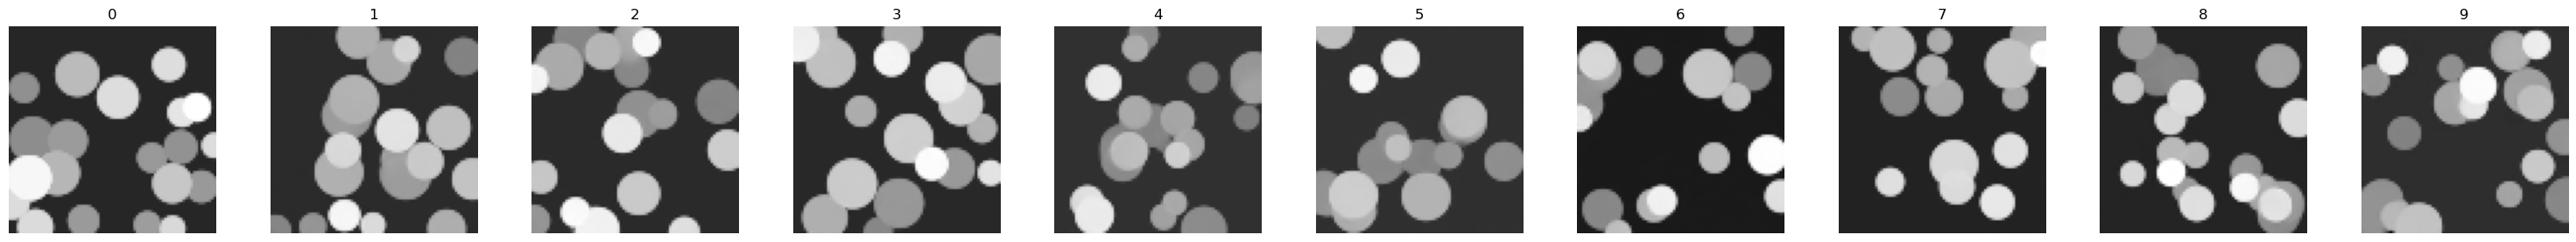

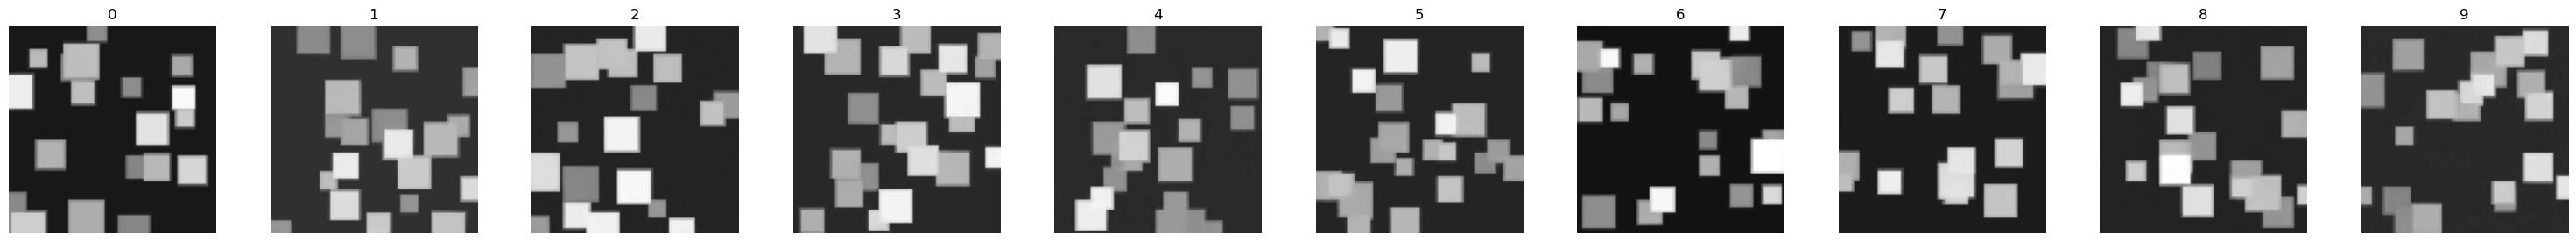

In [20]:
print( 'average_phi: ', average_phi , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
for i in range(len(all_samples)):
    show_im_set(torch.concatenate([test_sets[i][0:1].cpu(),all_samples[i].detach().cpu()]), 
                n_columns=10, vmin=0, vmax = 1)